# Applied Project - the **Australian Vehicle Prices** Data Set

Predict the price of a car based on large and diverse amount of features,
using the dataset (Kaggle)-(https://www.kaggle.com/datasets/nelgiriyewithana/australian-vehicle-prices/) <br>


**Students:**
**Tal sigman 322888389**
**Shachar Angelman 207273962**

 ## Import necessary packages

In [2]:
# data processing
import pandas as pd
import numpy as np

# data visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning library
import sklearn

from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
import shap

from imblearn.over_sampling import SMOTE

# common libraries
from random import randint, uniform
import joblib
from xgboost import XGBRegressor
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

## Load data

This dataset contains information about the prices of cars available in Australia for the year 2023. The dataset includes information such as the brand, year, model, whether the car is new or used, transmission type, engine specifications, fuel type, fuel consumption, kilometers, colors, location of sale, number of cylinders in the engine, body type, number of doors and seats, and the price of the car. It contains over 16,000 records of cars from various online platforms across Australia.

In [3]:
df = pd.read_csv("./Australian Vehicle Prices.csv")

In [4]:
df.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990


## Data Cleaning & Find outliers & Handling Missing Values

#### **Clean data:**

*   Split the Engine feature (in the format: 4 cyl, 2.2 L) to Engine_cylinder & Engine_volume, and remove the 'L' & 'cyl'.
*  Split the FuelConsumption feature (in the format: 8.7 L / 100 km) to Fuel_consumption_liter & Fuel_consumption_km, and remove the and remove the 'L' & 'km'.
*   Remove the words: 'Doors' or 'Seats' from the doors & seats features - we just want the number.
*   Remove some invalid characters from FuelType, BodyType, Transmission, Kilometres, and price features.
*   For now, replacing empty string (' ') with nan.
*   Convert some features to float







In [5]:
def clean_data(df):
  # split the Engine feature
  df['Engine'] = df['Engine'].str.replace('-','')
  df[['Engine_cylinder', 'Engine_volume']] = df['Engine'].str.split(',', expand=True)
  df['Engine_cylinder'] = df['Engine_cylinder'].str.replace('cyl', '').str.replace('0 L', '').str.replace('2 L', '').str.replace('-', '')
  df['Engine_volume'] = df['Engine_volume'].str.replace('L', '')

  # split the FuelConsumption feature
  df['FuelConsumption'] = df['FuelConsumption'].str.replace('-','')
  df[['Fuel_consumption_liter', 'Fuel_consumption_km']] = df['FuelConsumption'].str.split('/', expand=True)
  df['Fuel_consumption_liter'] = df['Fuel_consumption_liter'].str.replace('L', '').str.replace('-', '')
  df['Fuel_consumption_km'] = df['Fuel_consumption_km'].str.replace('km', '')

  # clean Doors & Seats:
  df['Doors'] = df['Doors'].astype(str).str.replace('Doors','').str.replace(' ','').apply(lambda x: '0' if ('Seats' in x or 'seats' in x) else x)
  df['Doors'] = df['Doors'].astype(float)

  df['Seats'] = df['Seats'].astype(str).str.replace('Seats', '').str.replace(' ', '')
  df['Seats'] = df['Seats'].astype(float)

  # remove rows where 'Doors' feature is 0
  df = df[df['Doors'] != 0]

  # clean other features
  df['FuelType'] = df['FuelType'].str.replace('-','')
  df['BodyType'] = df['BodyType'].str.replace('/', '')
  df['Transmission'] = df['Transmission'].replace('-','')
  df['Transmission'].replace('', np.nan, inplace=True)
  df['Kilometres'] = df['Kilometres'].str.replace('-', '').str.replace('/', '').str.replace(' ', '')
  df['Kilometres'].replace('', np.nan, inplace=True)
  df['Price'] = df['Price'].str.replace('POA','') # some rows contain 'POA' as the price

  df['FuelType'].replace('', np.nan,inplace=True)
  df['BodyType'].replace('', np.nan,inplace=True)
  df['Price'].replace('', np.nan,inplace=True)

  df = df.replace('', np.nan)


  # convert some features to float
  df['Engine_cylinder'] = df['Engine_cylinder'].astype(float)
  df['Engine_volume'] = df['Engine_volume'].astype(float)
  df['Fuel_consumption_liter'] = df['Fuel_consumption_liter'].astype(float)
  df['Fuel_consumption_km'] = df['Fuel_consumption_km'].astype(float)
  df['Kilometres'] = df['Kilometres'].astype(float)
  df['Price'] = df['Price'].astype(float)


  return df

In [6]:
df = clean_data(df)

Location extraction by state to reduce the number of categories

In [7]:
print("number of categories before the extraction: ", len(df['Location'].unique()))
df['State'] = df['Location'].str.extract(r'\, (\w+\-?\w+)')
df = df[df['State'].notna()] # remove nan values from state feature
print("number of categories after the extraction: ", len(df['State'].unique()))
df['State'].unique()

number of categories before the extraction:  619
number of categories after the extraction:  9


array(['NSW', 'VIC', 'QLD', 'SA', 'WA', 'ACT', 'AU-VIC', 'TAS', 'NT'],
      dtype=object)

*   Drop columns that are irrelevant for the price prediciton.
*   Drop the original 'FuelConsumption', 'Engine' columns - we split them in the clean data section
*   Drop categorical columns with too many categories ['ColourExtInt', 'Model', 'Car/Suv']
*   Drop columns with a fixed value (for example, Fuel_consumption_km)




In [8]:
df = df.drop(['Engine','FuelConsumption','Fuel_consumption_km','Title', 'CylindersinEngine', 'Location', 'ColourExtInt', 'Model', 'Car/Suv'], axis=1)

In [9]:
print(df.columns)

Index(['Brand', 'Year', 'UsedOrNew', 'Transmission', 'DriveType', 'FuelType',
       'Kilometres', 'BodyType', 'Doors', 'Seats', 'Price', 'Engine_cylinder',
       'Engine_volume', 'Fuel_consumption_liter', 'State'],
      dtype='object')


#### **Handle missing values:**

In [10]:
def handle_missing_values(df):
    # handle missing values:
    # for numeric features - the mean, while for categorical the mode:

    print("Missing values:")
    print(df.isnull().sum())
    print("========================================")
    print(df.isnull().sum()/df.shape[0]*100)

    mean_k = round(df['Kilometres'].astype(float).mean(), 2)
    mean_price = round(df['Price'].astype(float).mean(), 2)
    mean_doors = int(df['Doors'].astype(float).mean())
    mean_seats = int(df['Seats'].astype(float).mean())
    mean_engine_volume = round(df['Engine_volume'].astype(float).mean(), 2)
    mean_fuel_consumption_liter = round(df['Fuel_consumption_liter'].astype(float).mean(), 2)
    mean_engine_cylinder = round(df['Engine_cylinder'].astype(float).mean(), 2)

    df['Kilometres'].fillna(mean_k, inplace=True)
    df['Price'].fillna(mean_price, inplace=True)
    df['Doors'].fillna(mean_doors, inplace=True)
    df['Seats'].fillna(mean_seats, inplace=True)
    df['Engine_volume'].fillna(mean_engine_volume, inplace=True)
    df['Fuel_consumption_liter'].fillna(mean_fuel_consumption_liter, inplace=True)
    df['Engine_cylinder'].fillna(mean_engine_cylinder, inplace=True)



    mode_fuel_type = df['FuelType'].mode()[0]
    mode_used_or_new = df['UsedOrNew'].mode()[0]
    mode_transmission = df['Transmission'].mode()[0]
    mode_body = df['BodyType'].mode()[0]
    mode_drive_type = df['DriveType'].mode()[0]
    mode_year = df['Year'].mode()[0]
    mode_state = df['State'].mode()[0]



    df['FuelType'].fillna(mode_fuel_type, inplace=True)
    df['UsedOrNew'].fillna(mode_used_or_new, inplace=True)
    df['Transmission'].fillna(mode_transmission, inplace=True)
    df['BodyType'].fillna(mode_body, inplace=True)
    df['DriveType'].fillna(mode_drive_type, inplace=True)
    df['Year'].fillna(mode_year, inplace=True)
    df['State'].fillna(mode_state, inplace=True)


    print("\n\nAfter handling missing values:")
    print(df.isnull().sum())
    print("========================================")
    print(df.isnull().sum()/df.shape[0]*100)

In [11]:
# split to train and test, and handle missing values on train:
df_train, df_test = train_test_split(df, test_size=0.25)

# handle missing values on train & test:
print("Train:\n")
handle_missing_values(df_train)
print("\n\n\nTest:\n")
handle_missing_values(df_test)

Train:

Missing values:
Brand                        0
Year                         0
UsedOrNew                    0
Transmission               173
DriveType                    0
FuelType                   452
Kilometres                 108
BodyType                   216
Doors                     1221
Seats                     1238
Price                       40
Engine_cylinder           1289
Engine_volume             1290
Fuel_consumption_liter    1238
State                        0
dtype: int64
Brand                      0.000000
Year                       0.000000
UsedOrNew                  0.000000
Transmission               1.422814
DriveType                  0.000000
FuelType                   3.717411
Kilometres                 0.888231
BodyType                   1.776462
Doors                     10.041944
Seats                     10.181758
Price                      0.328974
Engine_cylinder           10.601201
Engine_volume             10.609425
Fuel_consumption_liter    10.1

#### **Handeling Outliers**

After cleaning data and handling missing values, we calculated the outliers of each feature according to the IQR approach (IQR=Q3-Q1), the ones falling below:
 Q1-1.5IQR or above Q3 + 1.5IQR, such that Q1 is the 25th percentile and Q3 is the 75th percentile of the dataset.
 The features with the most outliers:

*   Price (5% of the data)
*   Kilometres (1.5% of the data)
*   Year (1% of the data)


We have a very few outliers in Price, Kilometres, and Year (outliers in rest of the features are negligible), so we decided to remove the outliers from these features.

In [12]:
def quantiles_and_bounds(df, feature):
  print(f"Feature: {feature}")

  count = df[feature].count()
  print(f"Count: {count}")

  Q1 = df[feature].quantile(0.25)
  Q3 = df[feature].quantile(0.75)
  IQR = Q3 - Q1

  print("25th quartile: ", Q1)
  print("75th quartile: ", Q3)
  print(f"IQR: {IQR}")

  upper = int(Q3 + 1.5*IQR)
  print("Upper Bound:", upper)

  lower = int(Q1 - 1.5*IQR)
  print("Lower Bound:", lower)

  print(len(df[df[feature] > upper]) / count * 100)
  print(len(df[df[feature] < lower]) / count * 100)

  return lower, upper


def remove_outliers(df, feature, lower, upper):
  old_df = df.copy()

  df = df[df[feature] < upper]
  df = df[df[feature] > lower]

  return old_df, df


def before_after_outliers_plots(feature, df_with_outliers, df_without_outliers):
  plt.figure(figsize=(16,8))

  plt.subplot(2,2,1)
  sns.histplot(df_with_outliers[feature], kde=True)
  plt.title("Histogram before outlier removal")

  plt.subplot(2,2,2)
  sns.boxplot(data = df_with_outliers[feature])
  plt.title("Boxplot before outlier removal")

  plt.subplot(2,2,3)
  sns.histplot(df_without_outliers[feature], kde=True)
  plt.title("Histogram after outlier removal")

  plt.subplot(2,2,4)
  sns.boxplot(data = df_without_outliers[feature])
  plt.title("Boxplot after outlier removal")

  plt.show()

Train Outliers:

Feature: Price
Count: 12159
25th quartile:  18990.0
75th quartile:  42877.0
IQR: 23887.0
Upper Bound: 78707
Lower Bound: -16840
5.1731227897031005
0.0


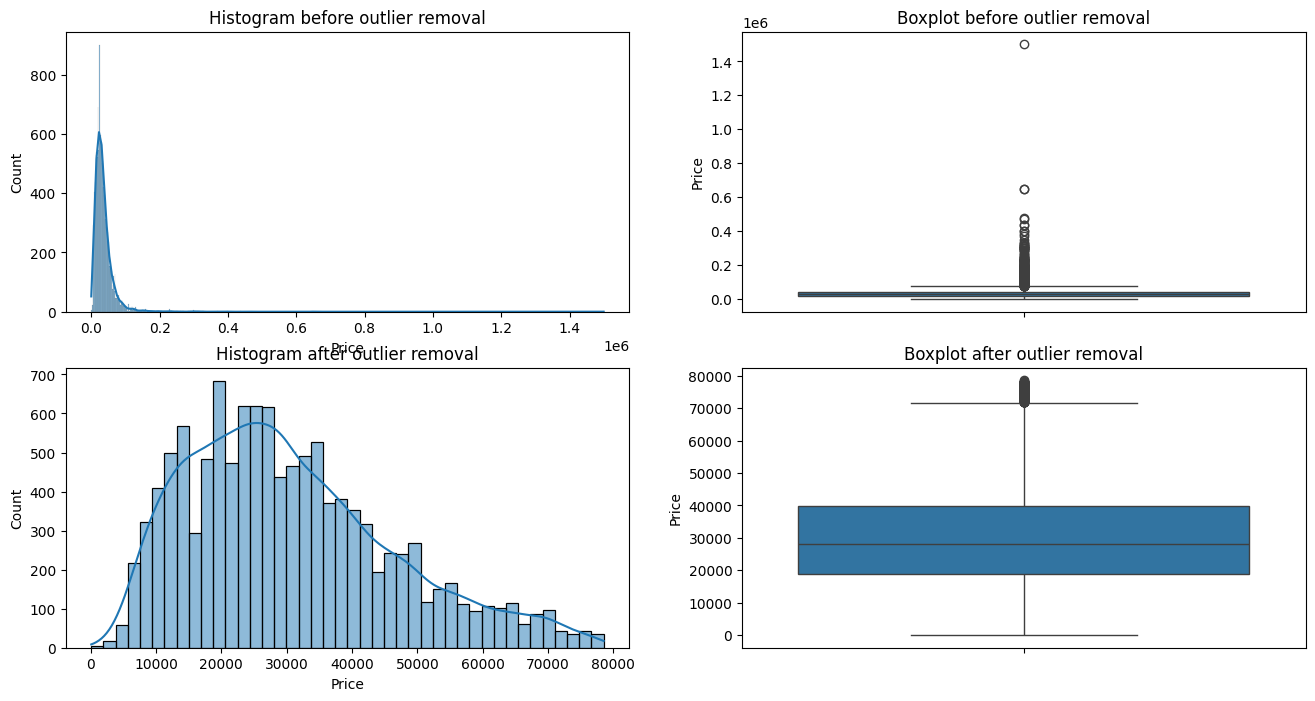




Feature: Kilometres
Count: 11530
25th quartile:  45000.0
75th quartile:  148669.25
IQR: 103669.25
Upper Bound: 304173
Lower Bound: -110503
1.6912402428447528
0.0


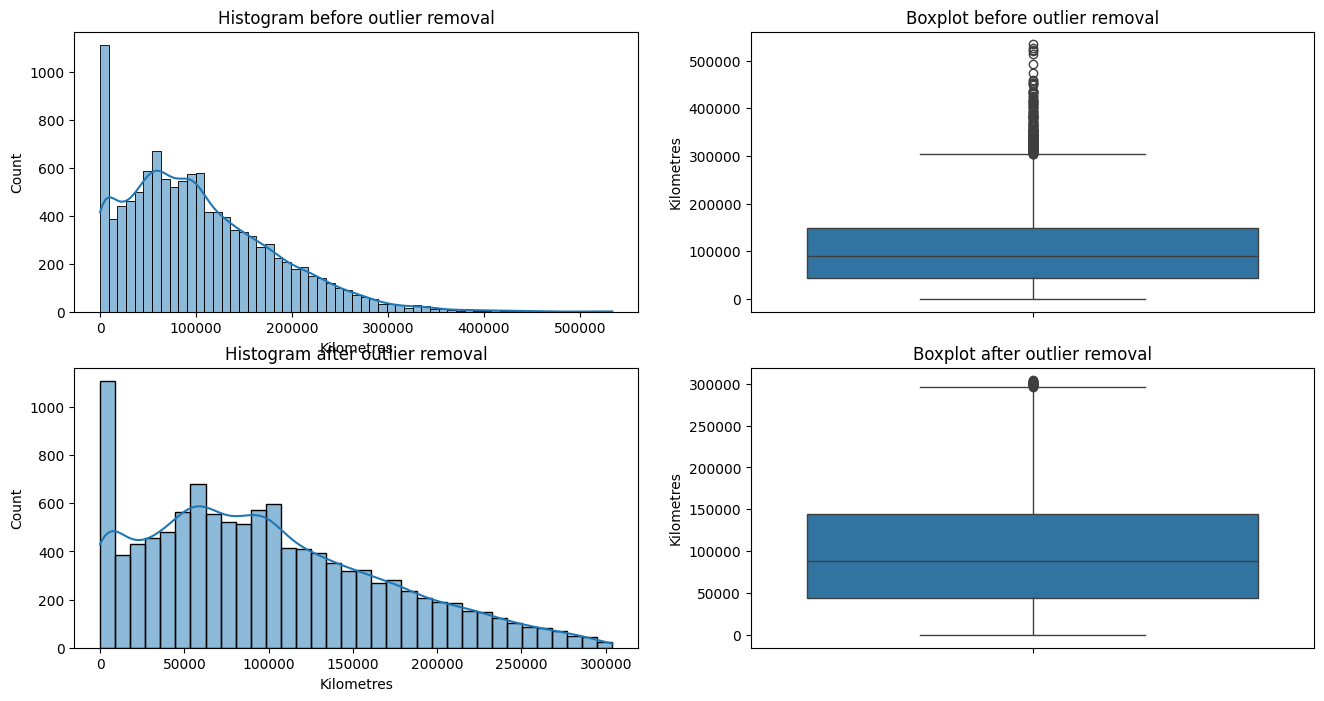




Feature: Year
Count: 11335
25th quartile:  2013.0
75th quartile:  2020.0
IQR: 7.0
Upper Bound: 2030
Lower Bound: 2002
0.0
0.9616232906925452


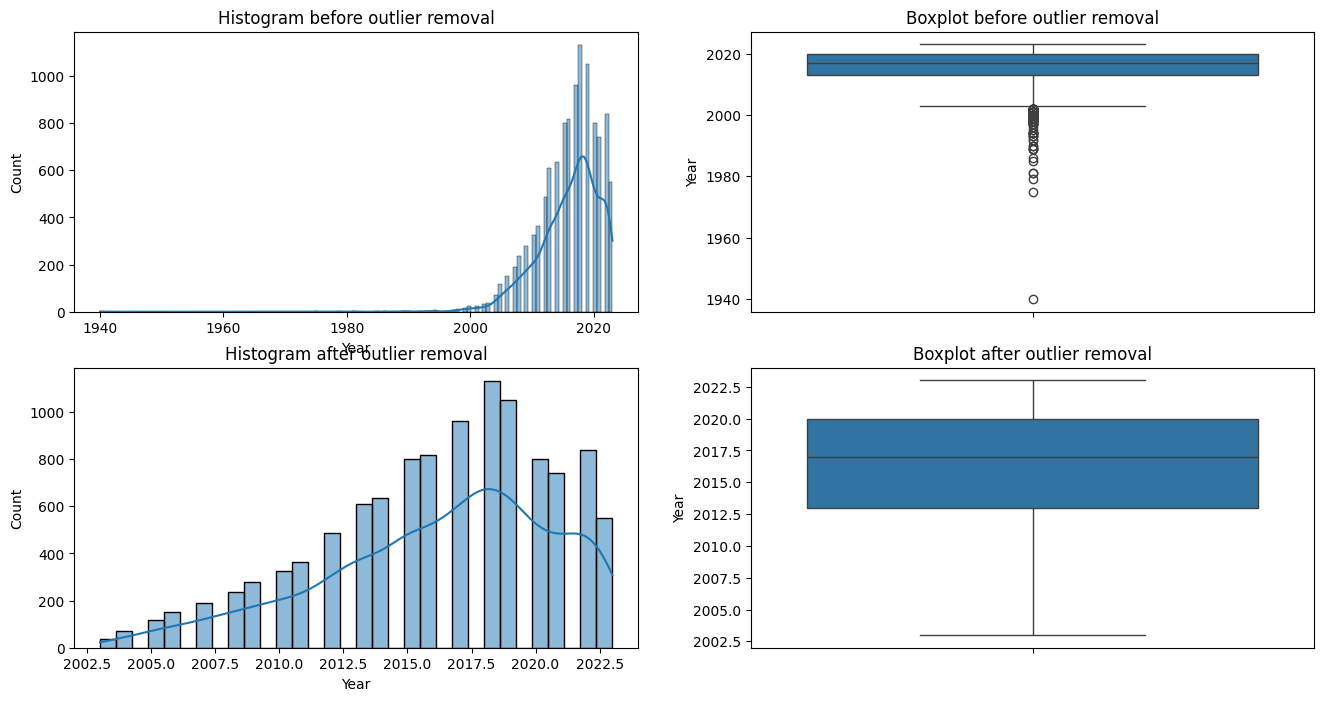







Test Outliers:

Feature: Price
Count: 4054
25th quartile:  18513.75
75th quartile:  42990.0
IQR: 24476.25
Upper Bound: 79704
Lower Bound: -18200
5.229403058707449
0.0


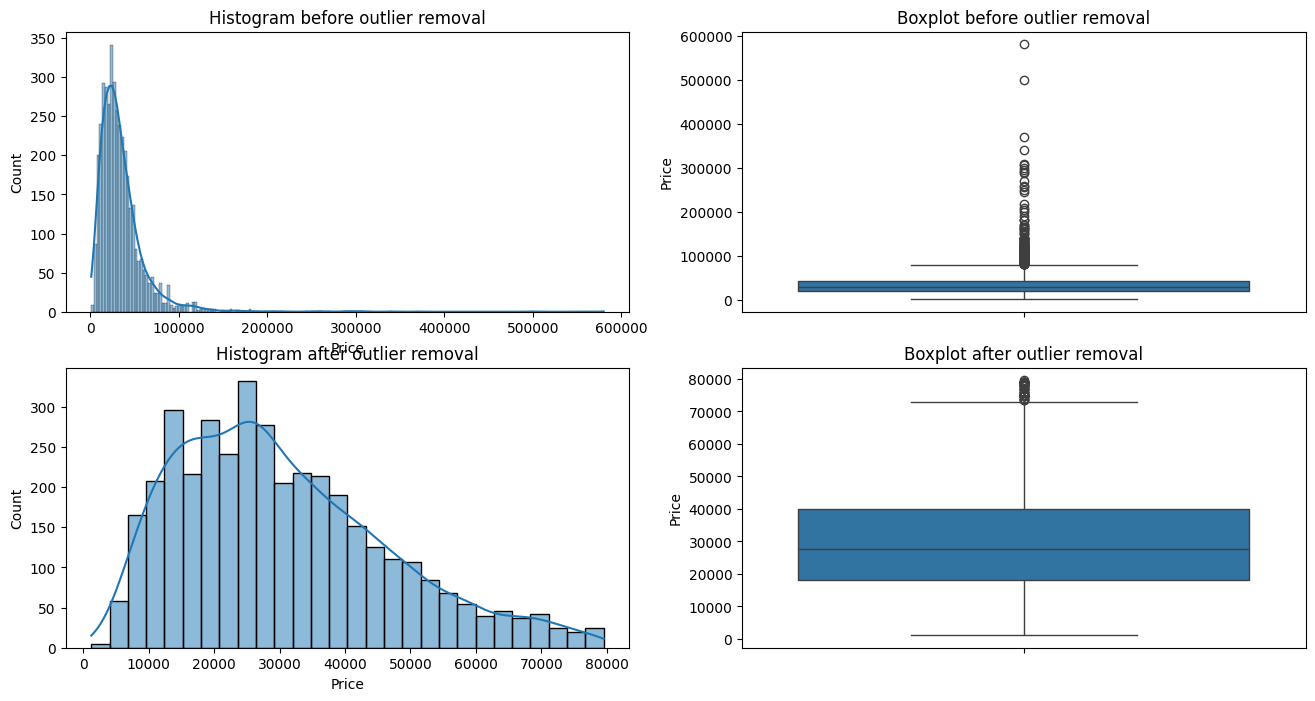




Feature: Kilometres
Count: 3842
25th quartile:  47729.0
75th quartile:  153645.5
IQR: 105916.5
Upper Bound: 312520
Lower Bound: -111145
1.5616866215512752
0.0


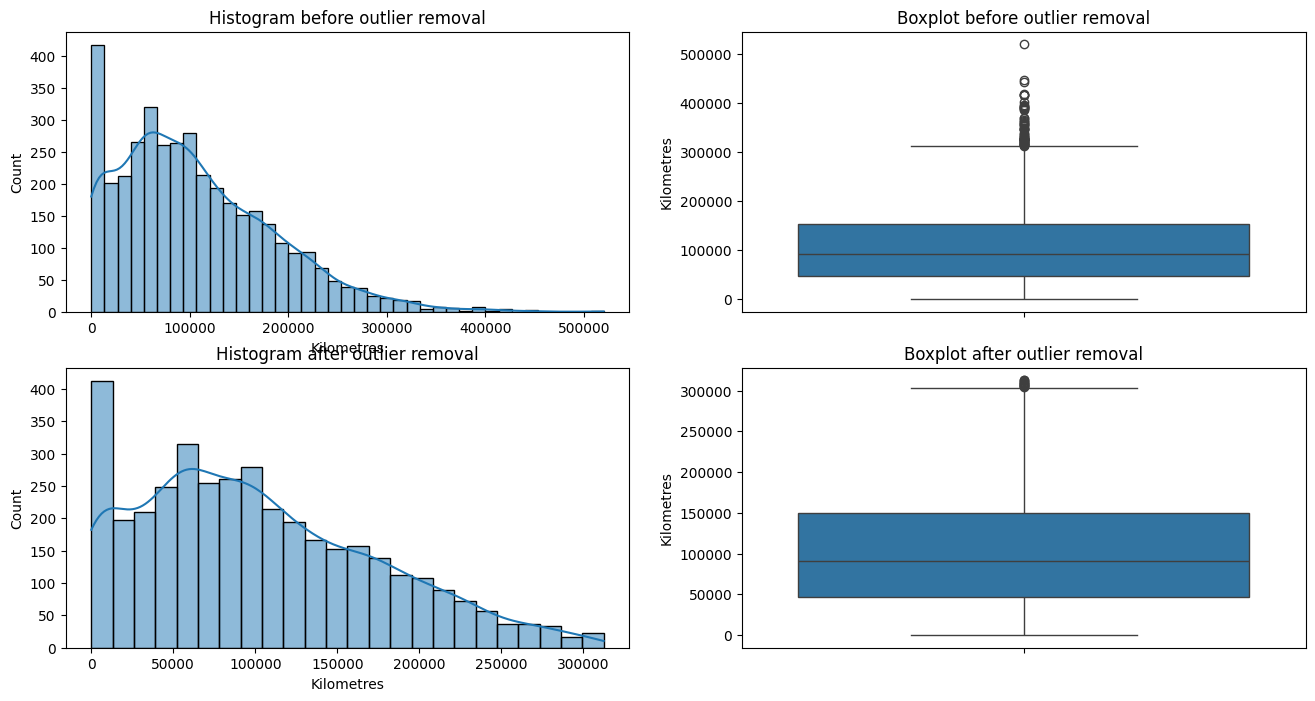




Feature: Year
Count: 3782
25th quartile:  2013.0
75th quartile:  2020.0
IQR: 7.0
Upper Bound: 2030
Lower Bound: 2002
0.0
0.9254362771020624


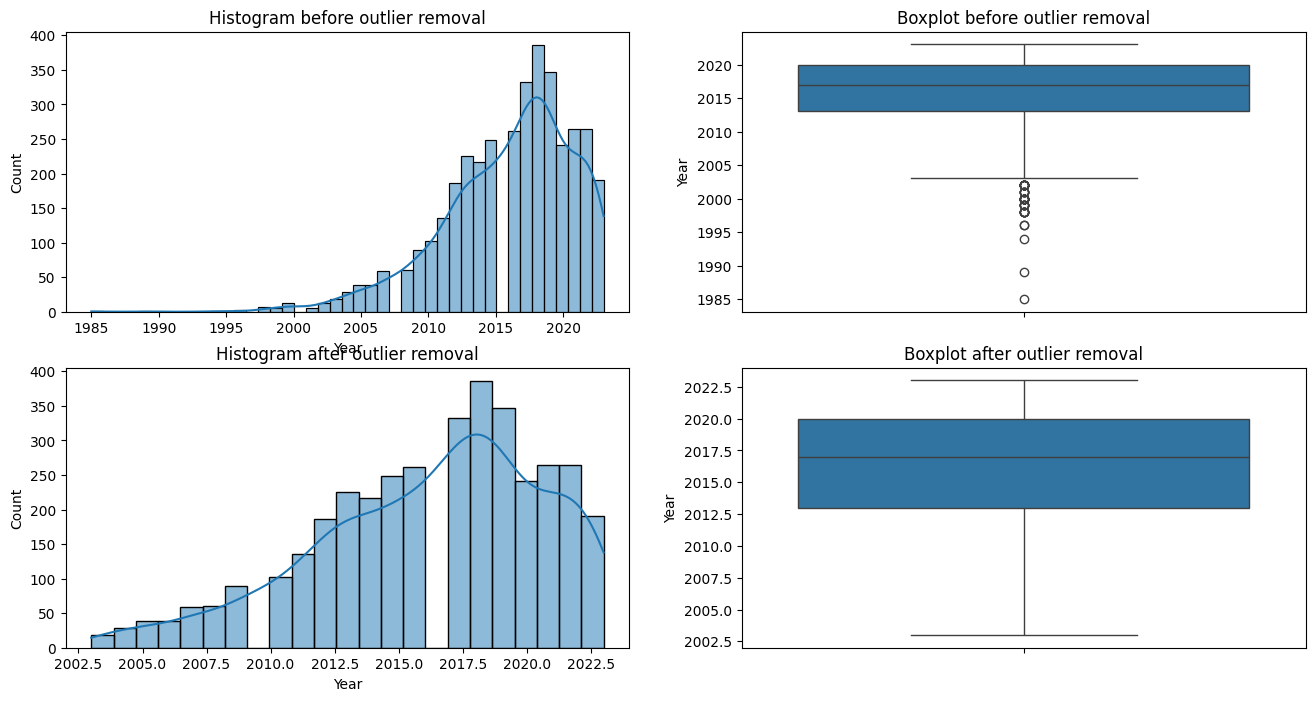

In [13]:
# Calculate outliers, remove, and display the effect for: Price, Kilometres, Year using KDE & BoxPlot

def handling_df_outliers(df):
  lower, upper = quantiles_and_bounds(df, 'Price')
  old_df, df = remove_outliers(df, 'Price', lower, upper)
  before_after_outliers_plots('Price', old_df, df)

  print('\n\n')
  lower, upper = quantiles_and_bounds(df, 'Kilometres')
  old_df, df = remove_outliers(df, 'Kilometres', lower, upper)
  before_after_outliers_plots('Kilometres', old_df, df)

  print('\n\n')
  lower, upper = quantiles_and_bounds(df, 'Year')
  old_df, df = remove_outliers(df, 'Year', lower, upper)
  before_after_outliers_plots('Year', old_df , df)

  return df


# Handling train outliers:
print("Train Outliers:\n")
df_train = handling_df_outliers(df_train)

# Handling test outliers:
print('\n\n\n\n\n\nTest Outliers:\n')
df_test = handling_df_outliers(df_test)

According to the above section, we saw (using the KDE), a long right tail for the price & kilometers features, and a long left tail for the year feature. Such tails are an indication for outliers, and we took a another look using the BoxPlot which is another way for outliers detection.

## **Visualizing Price distribution & Correlations**


**Density estimation of the price feature using Histograms & KDE**


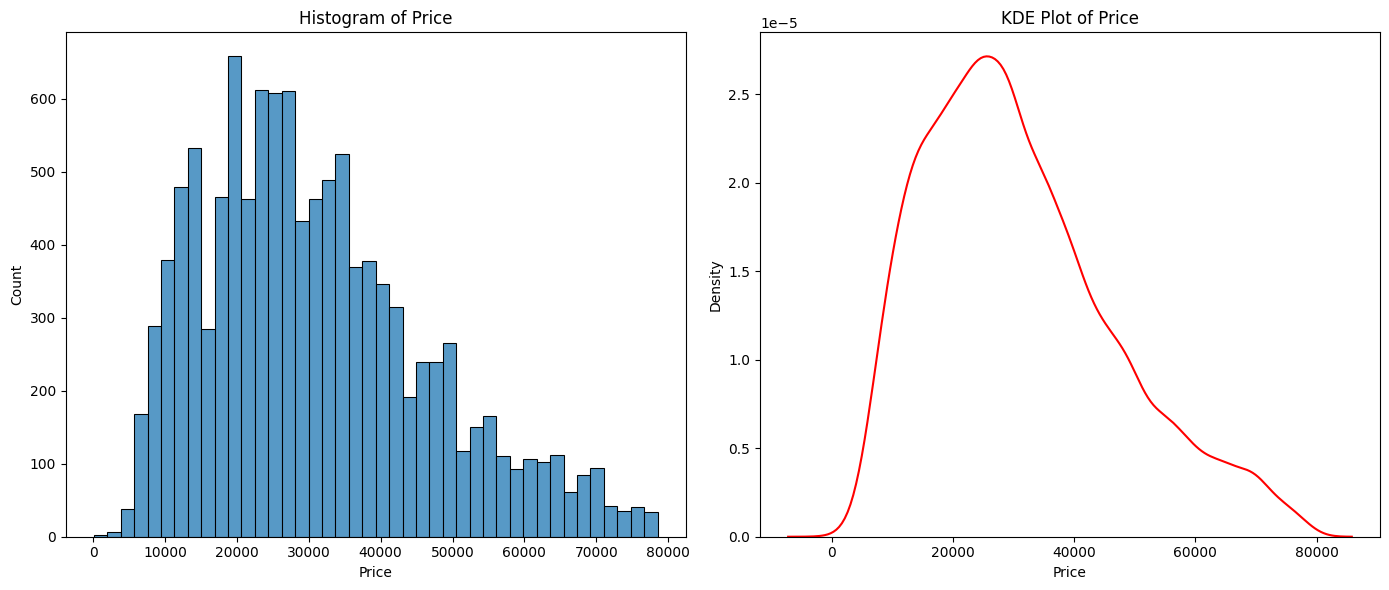

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot histogram of the 'Price' column
sns.histplot(data=df_train, x='Price', ax=axes[0])
axes[0].set_title('Histogram of Price')

# Plot KDE plot of the 'Price' column
sns.kdeplot(data=df_train, x='Price', ax=axes[1], color='red')
axes[1].set_title('KDE Plot of Price')

plt.tight_layout()
plt.show()

These plots show the density estimation of the price feature. In the previous outliers section we saw in the price KDE plot a long right tail, which was an indication for outliers, but now (after we removed the price outliers) we don't see such a long right tail.

Let's also take a look with a boxplot.

A Boxplot may indicate:
*   outliers and their values
*   if data is symmetrical, and how tightly the data is grouped.
*   if data is skewed.



<Axes: xlabel='Price'>

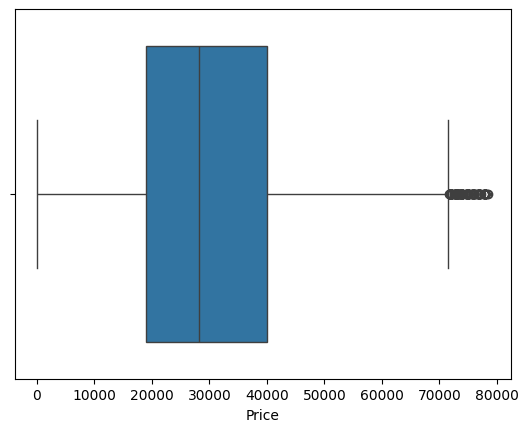

In [15]:
sns.boxplot(df_train.Price, orient='h')

*   The line inside the box represents the price median (almost 30k)
*   The box itself represents the IQR, which is the middle 50% of the data. The bottom of the box (Q1) marks the 25th percentile, and the top (Q3) marks the 75th percentile (we calculated the IQR, Q1, Q3 in the price outliers section).
*   Outliers, we see in the price section.

Now, let's zoom in:

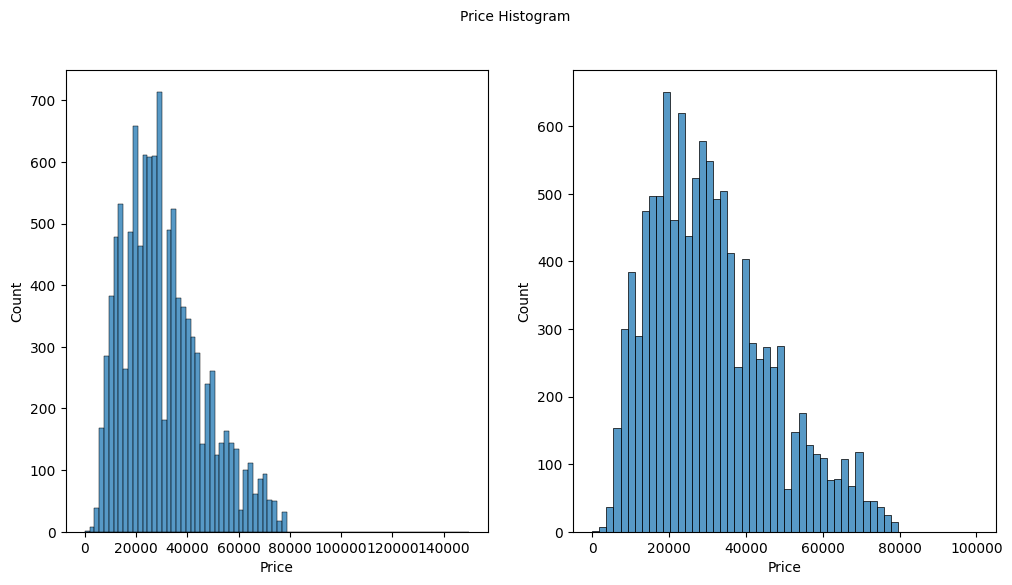

In [16]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
fig.subplots_adjust(hspace=0.5)
sns.histplot(data=df_train['Price'], binrange=(0, 150000), ax=axes[0])
sns.histplot(data=df_train['Price'], binrange=(0, 100000), ax=axes[1])
fig.suptitle("Price Histogram", fontsize=10)
fig.subplots_adjust(hspace=0.5)

We can see that the price probability distribution is **asymmetric**. We have a **positive skew** - because the right tail is longer (the mass of the distribution is concentrated on the left of the figure).

In a distribution with positive skewness (right-skewed):
*   The right tail of the distribution is longer or "fatter" than the left.
*   The mean is greater than the median, and the mode is less than both mean and median.
*   Lower values are clustered in the “hill” of the distribution, while extreme values are in the long right tail.



**Calculate Skewness & Kurtosis**

We will measure how asymmetrical is it, using a skewness
measure, and how thick ("heavy") is the tail, using the kurtosis measure, which is a measure of whether the data is a heavy-tailed or light-tailed relative to a normal distribution.

In [17]:
# calculate the price's Skewness & Kurtosis
print(f"Price Skewness:({df_train['Price'].skew():.2f}), Price Kurtosis:({df_train['Price'].kurt():.2f}) ")

Price Skewness:(0.71), Price Kurtosis:(-0.00) 


Features with low kurtosis tend to have **light tails, or lack of outliers**, and as we can see, the price feature has a small kurtosis value, which is make sense, because in the previous sections, we saw that after we removed the price outliers, the right tail became to a "light tail". Our skewness is also relatively low.


#### Measure Correlations to the **Price feature** (the target feature):

Define numeric, ordinal and categorical columns

In [18]:
numeric_columns = df_train.dtypes[(df_train.dtypes=="float64") | (df_train.dtypes=="int64")].index.tolist()
very_numerical = [nc for nc in numeric_columns if df_train[nc].nunique() > 20]
categorical_columns = [c for c in df_train.columns if c not in numeric_columns]
ordinals_columns = list(set(numeric_columns) - set(very_numerical))


print("very numerical: ", very_numerical)
print("ordinals columns: ",ordinals_columns)
print("categorical columns: ",categorical_columns)

very numerical:  ['Year', 'Kilometres', 'Price', 'Engine_volume', 'Fuel_consumption_liter']
ordinals columns:  ['Engine_cylinder', 'Seats', 'Doors']
categorical columns:  ['Brand', 'UsedOrNew', 'Transmission', 'DriveType', 'FuelType', 'BodyType', 'State']


We will use Pearson for the very numerical columns and Spearman, which should work better for the ordinals columns.

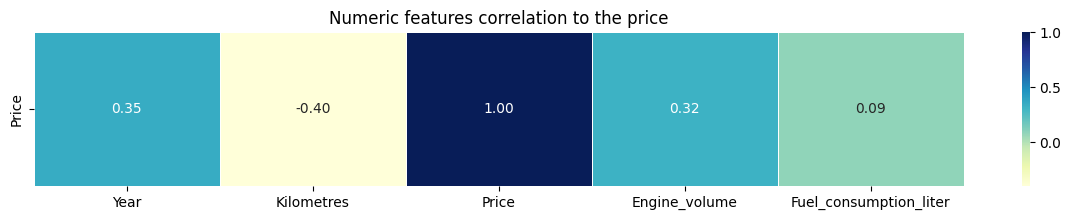

In [19]:
df_corr = df[very_numerical].corr(method="pearson").loc[["Price"]]
fig, ax = plt.subplots(figsize=(15,2))
sns.heatmap(df_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)
plt.title('Numeric features correlation to the price')
plt.show()

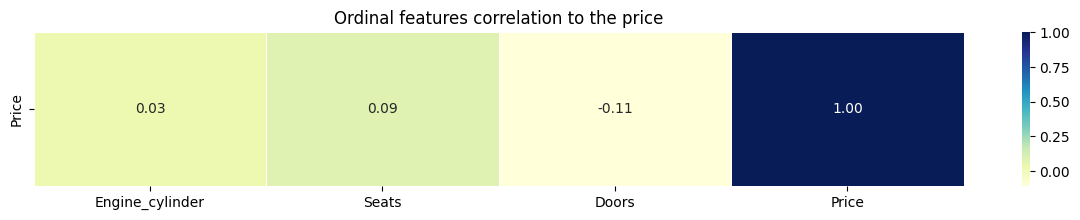

In [20]:
ordinals_columns.append('Price')
df_corr = df_train[ordinals_columns].corr(method="spearman").loc[["Price"]]
fig, ax = plt.subplots(figsize=(15,2))
sns.heatmap(df_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)
plt.title('Ordinal features correlation to the price')
plt.show()

* **Positive correlation:** A correlation coefficient close to +1 indicates a strong positive linear relationship between the two variables. This means that as one variable increases, the other tends to increase as well.
* **Negative correlation (Inverse correlation):** A correlation coefficient close to -1 indicates a strong negative linear relationship between the two variables. This means that as one variable increases, the other tends to decrease.


According to the plots, the strongest correlation features are the "Year", "Kilometers" (not a significant correlation), which indicates that, none of the 'very_numeric' and 'ordinal' features, has a significant correlation to the target feature (the price).

Measure correlations between non target numeric features (in order to see if we have any redundency)

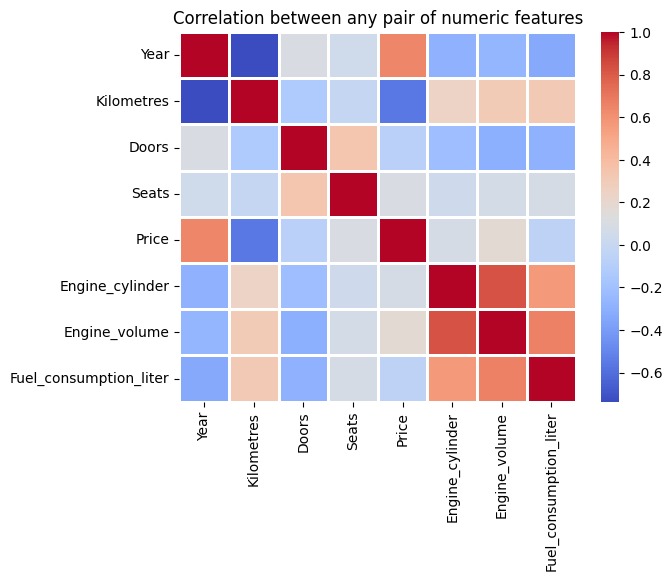

In [21]:
dtf_corr = df_train[numeric_columns].corr(method="pearson")
sns.heatmap(dtf_corr, annot=False, fmt='.2f', cmap="coolwarm", cbar=True, linewidths=1)
plt.title('Correlation between any pair of numeric features')
plt.show()

We can see that we have a high postive correlation between the 'Engine_cylinder', and 'Engine_volume', and an inverse correlation between the 'Year' and 'Kilometers'. (We will check later their impact on the price and will decide what to do with them)

## Preprocessing

We have already split the data to train and test (during the handle missing values section)

#### "One hot encoding" for categorical variables

Handling large number of values

check value_counts for finding columns with too many categories  

In [22]:
for i in categorical_columns:
    print(f'{i}--->{len(df_train[i].unique())}')

Brand--->57
UsedOrNew--->3
Transmission--->2
DriveType--->5
FuelType--->7
BodyType--->10
State--->8


show the value count for "FuelType", "BodyType", "State", "Brand" (columns with many categories)



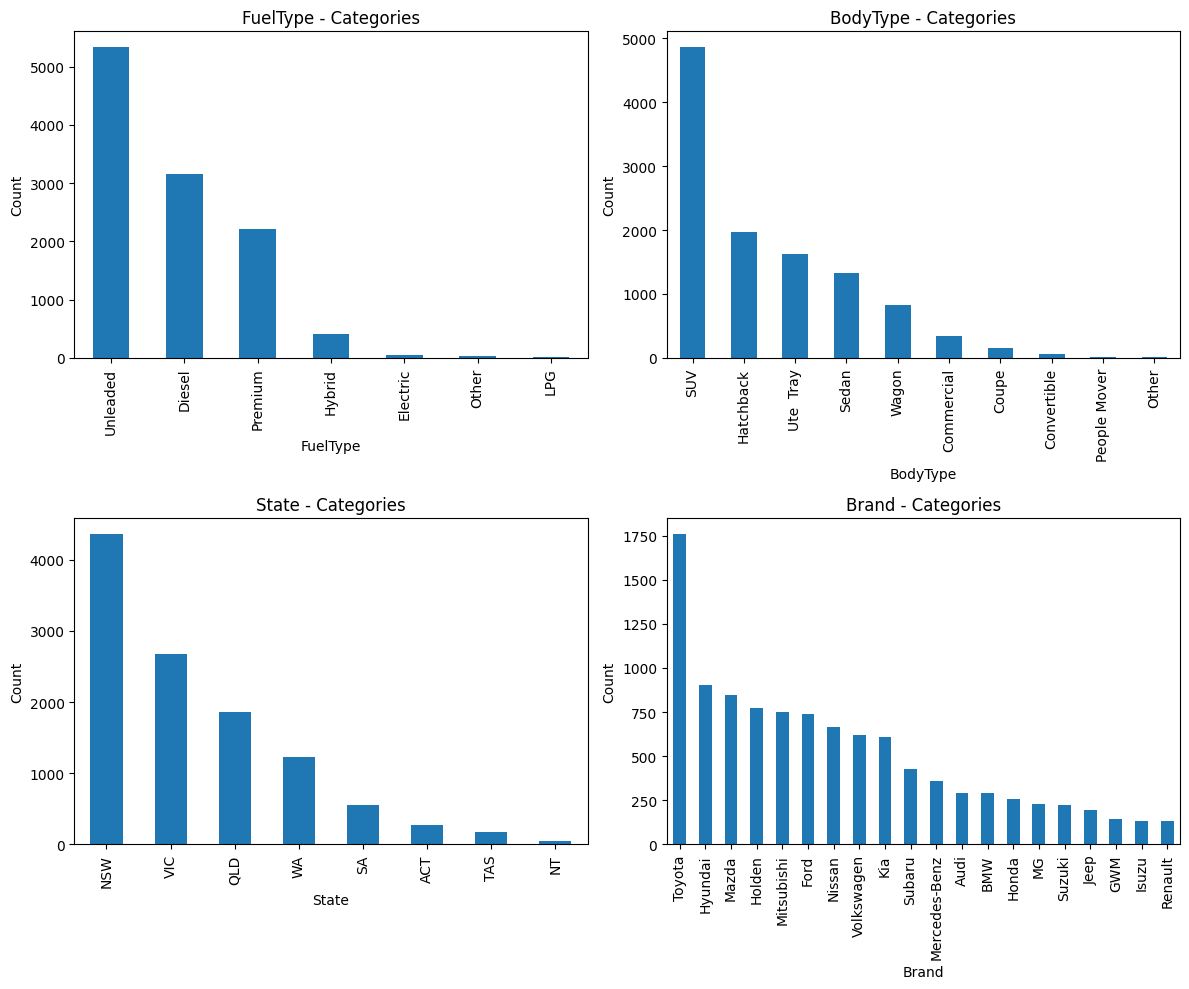

In [23]:
# save a copies of brand df
df_train_brand_copy = df_train['Brand'].copy()
df_test_brand_copy = df_test['Brand'].copy()

# columns names
columns_many_cat = ["FuelType", "BodyType", "State", 'Brand']
vc = []

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Iterate over each column name and plot its value counts
for i, col in enumerate(columns_many_cat):
    vc.append(df_train[col].value_counts())

    # Plot the bar chart for the column
    vc[i].head(20).plot(kind='bar', ax=axes[i//2, i%2], title=f"{col} - Categories")
    axes[i//2, i%2].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

 Combine infrequent categories into a single category (reduce the cardinality). This reduces the number of unique categories and also reduces the sparsity in the data representation.

In [24]:
high_categories = []
high_categories.append(vc[0][vc[0] >= 1000])
high_categories.append(vc[1][vc[1] >= 500])
high_categories.append(vc[2][vc[2] >= 1000])
high_categories.append(vc[3][vc[3] >= 800])

Create new columns so the infrequent categories will be combined into the "other" category

In [25]:
new_col_train = []
new_col_test = []
for i, col in enumerate(columns_many_cat):
    new_col_train.append(df_train[col].apply(lambda x: x if x in high_categories[i] else 'Other'))
    new_col_test.append(df_test[col].apply(lambda x: x if x in high_categories[i] else 'Other'))


The value count of the new columns

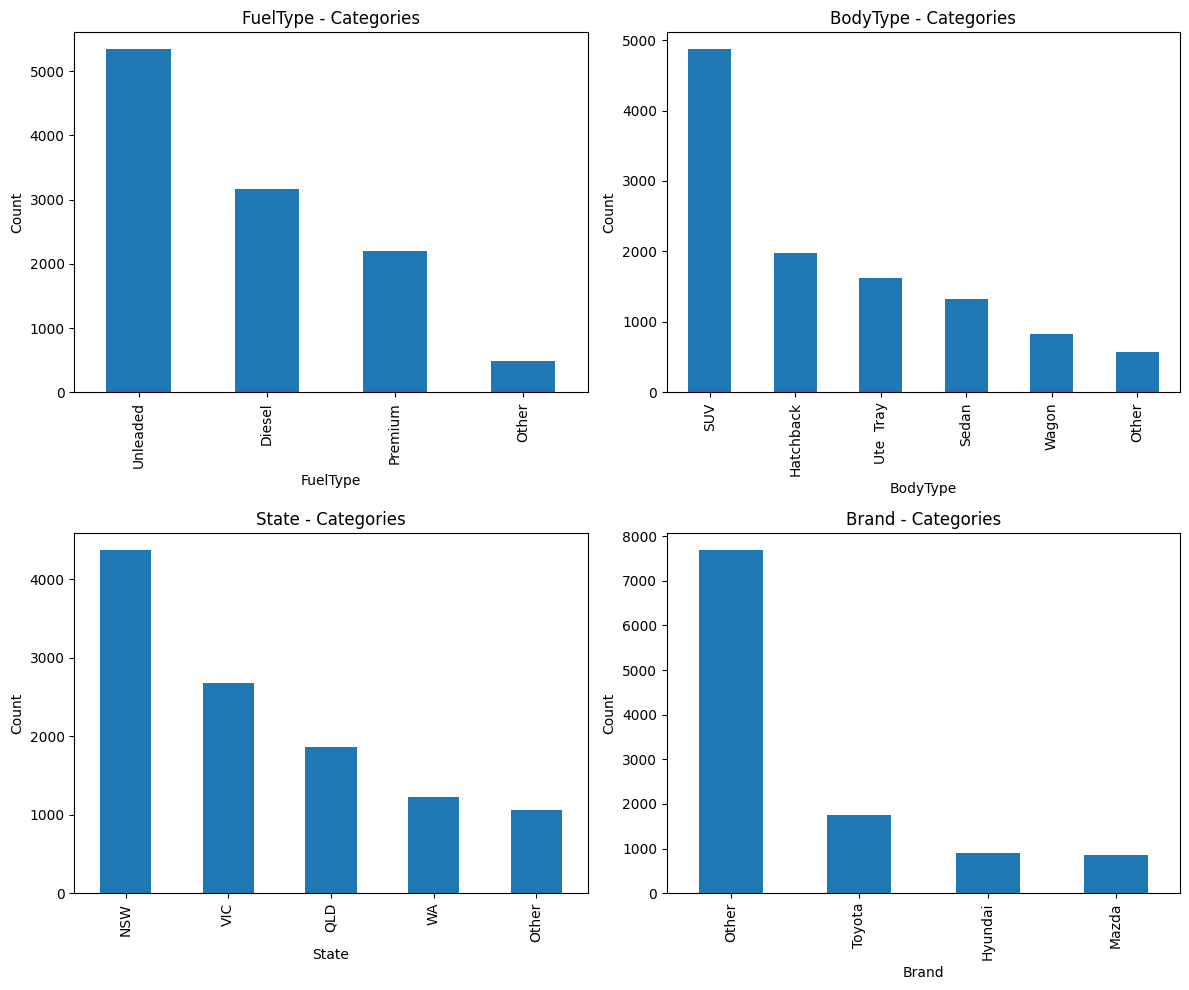

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot for 'FuelType'
new_col_train[0].value_counts().plot(kind='bar', ax=axes[0, 0], title='FuelType - Categories')
axes[0, 0].set_ylabel('Count')

# Plot for 'BodyType'
new_col_train[1].value_counts().plot(kind='bar', ax=axes[0, 1], title='BodyType - Categories')
axes[0, 1].set_ylabel('Count')

# Plot for 'State'
new_col_train[2].value_counts().plot(kind='bar', ax=axes[1, 0], title='State - Categories')
axes[1, 0].set_ylabel('Count')

# Plot for 'Brand'
new_col_train[3].value_counts().plot(kind='bar', ax=axes[1, 1], title='Brand - Categories')
axes[1, 1].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()


One hot encoding (dummy variables)

In [27]:
# Initialize train and test DataFrames
dummy_train = pd.DataFrame()
dummy_test = pd.DataFrame()

# Iterate over each new column in new_col_train and new_col_test to create dummy variables.
#  pd.get_dummies function are used to convert categorical data into numerical data
for col_train, col_test in zip(new_col_train, new_col_test):

    # Get dummy variables for training data and concatenate to dummy_train DataFrame
    dummy_train = pd.concat([dummy_train, pd.get_dummies(col_train, prefix=col_train.name, dtype=int)], axis=1)

    # Get dummy variables for testing data and concatenate to dummy_test DataFrame
    dummy_test = pd.concat([dummy_test, pd.get_dummies(col_test, prefix=col_test.name, dtype=int)], axis=1)

Check our new categorical features using a violin plot, which shows the shape of a data set by using a Probability Density Function (PDF), and is effectively a smoothed-over histogram.

The width of the PDF describes how frequently that value occurs in the data set. The wider regions of the density plot indicate values that occur more frequently, while narrower regions of the density plot indicate values that occur less frequently.

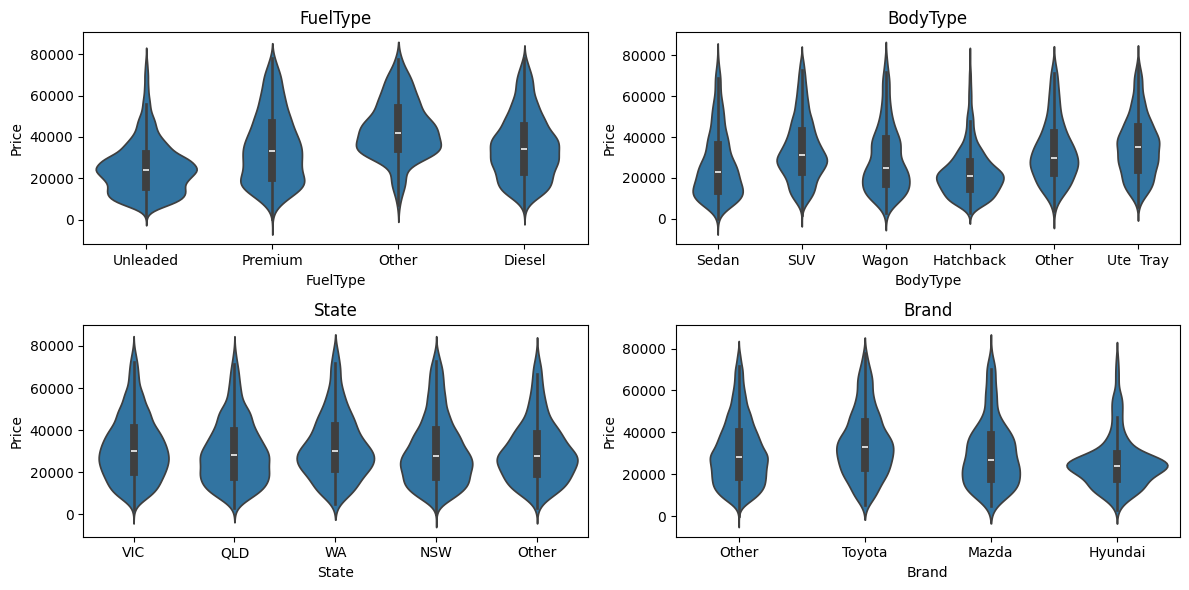

In [28]:
plt.figure(figsize=(12, 6))

# Iterate over each new column in new_col_train to plot violin plots
for i, col_train in enumerate(new_col_train):
    plt.subplot(2, 2, i+1)
    sns.violinplot(x=col_train, y=df_train['Price'])
    plt.title(col_train.name)

plt.tight_layout()
plt.show()

According to the plots, we can see that:


*   State categories have the same price distribution (the median is almost the same)
*   Toyota has the highest median price (Later we will see that this brand has the greatest impact on the price among all brands).
*   FuelType other has the highest median price, while the Unleaded type has the lowest
*   BodyType 'Ute Tray' has the highest median price, while 'Hatchback' has the lowest


Concat the one-hot attributes and drop the original

In [29]:
# Concatenate dummy_train and dummy_test to df_train and df_test respectively
df_train = pd.concat([df_train, dummy_train], axis=1)
df_test = pd.concat([df_test, dummy_test], axis=1)

In [30]:
# List of categorical columns to drop
categorical_columns_to_drop = columns_many_cat

# Drop each categorical column from df_train and df_test
for col in categorical_columns_to_drop:
    if col in df_train.columns:
        df_train = df_train.drop(col, axis=1)
    if col in df_test.columns:
        df_test = df_test.drop(col, axis=1)

one-hot for the other categorical columns

In [31]:
# Check if each column that we dropped is in categorical columns list and remove it if present
columns_to_remove = columns_many_cat
for col in columns_to_remove:
    if col in categorical_columns:
        categorical_columns.remove(col)

# one-hot
for col in categorical_columns:
  dummy_train = pd.get_dummies(df_train[col], prefix=col, dtype=int)
  dummy_test = pd.get_dummies(df_test[col], prefix=col, dtype=int)
  df_train = pd.concat([df_train, dummy_train], axis=1)
  df_test = pd.concat([df_test, dummy_test], axis=1)
  df_train = df_train.drop(col, axis=1)
  df_test = df_test.drop(col, axis=1)


In [32]:
print(f"Current columns: {df_train.columns}")
print(f"Amount of columns: {len(df_train.columns)}")

Current columns: Index(['Year', 'Kilometres', 'Doors', 'Seats', 'Price', 'Engine_cylinder',
       'Engine_volume', 'Fuel_consumption_liter', 'FuelType_Diesel',
       'FuelType_Other', 'FuelType_Premium', 'FuelType_Unleaded',
       'BodyType_Hatchback', 'BodyType_Other', 'BodyType_SUV',
       'BodyType_Sedan', 'BodyType_Ute  Tray', 'BodyType_Wagon', 'State_NSW',
       'State_Other', 'State_QLD', 'State_VIC', 'State_WA', 'Brand_Hyundai',
       'Brand_Mazda', 'Brand_Other', 'Brand_Toyota', 'UsedOrNew_DEMO',
       'UsedOrNew_NEW', 'UsedOrNew_USED', 'Transmission_Automatic',
       'Transmission_Manual', 'DriveType_4WD', 'DriveType_AWD',
       'DriveType_Front', 'DriveType_Other', 'DriveType_Rear'],
      dtype='object')
Amount of columns: 37


## A Baseline XGBoost Model


* XGBoost is a decision-tree-based ensemble ML algorithm that uses a gradient boosting framework, and it is known for it's computational efficiency, feature importance analysis, and handling of missing values.
* We will use XGBRegressor - a regression specific implementation of XGBoost

In [33]:
# separate x from y
x_train = df_train.drop('Price',axis=1)
y_train = df_train['Price']

print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")


x_test = df_test.drop('Price',axis=1)
y_test = df_test['Price']

print(f"x_test.shape: {x_test.shape}")
print(f"y_test.shape: {y_test.shape}")

# define model
model = XGBRegressor()

x_train.shape: (11194, 36)
y_train.shape: (11194,)
x_test.shape: (3734, 36)
y_test.shape: (3734,)


#### Evaluation metrics for the model

*   Mean Absolute Error (MAE) measures the average absolute difference between the predicted and actual values. In the negative MAE, good performance is indicated by a smaller absolute value.
*  Root Mean Squared Error measures the average difference between values predicted by a model and the actual values. It provides an estimation of how well the model is able to predict the target value. negative RMSE is the negative of this value.
* R2 is a measure that provides information about the goodness of fit of a model. In the context of regression it is a statistical measure of how well the regression line approximates the actual data.
* Max Error measures the maximum residual error, which is the largest difference between predicted and actual values.



In [34]:
# Define evaluation metrics
scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2', 'max_error']

#### 10-cross-validation

In [35]:
def run_10_cross_validation(model, x_train, y_train):
  cv = KFold(n_splits=10, shuffle=True)
  return cross_validate(model, x_train, y_train, cv=cv, scoring=scoring,  return_estimator=True)


def get_the_best_model(results):
  combined_results = np.mean([results['test_' + 'neg_mean_absolute_error'], results['test_' + 'neg_root_mean_squared_error'], results['test_' + 'r2'], results['test_' + 'max_error']], axis=0)
  best_model_idx = np.argmax(combined_results)
  print(f"the best model index: {best_model_idx}")
  return results['estimator'][best_model_idx]


results = run_10_cross_validation(model, x_train, y_train)
best_model = get_the_best_model(results)

the best model index: 8


#### Model Evaluation

In [36]:
def evaluate_results(results):
  print("Train results:")

  # The mean and standard deviation of each evaluation metric
  print("Negative Mean Absolute Error :","{:,.0f}".format(results['test_' + 'neg_mean_absolute_error'].mean()),  "(+/- {:,.0f})".format(results['test_' + 'neg_mean_absolute_error'].std()))
  print("Negative Root Mean Squared Error :","{:,.0f}".format(results['test_' + 'neg_root_mean_squared_error'].mean()),  "(+/- {:,.0f})".format(results['test_' + 'neg_root_mean_squared_error'].std()))
  print("R2 :","{:,.4f}".format(results['test_' + 'r2'].mean()),  "(+/- {:,.4f})".format(results['test_' + 'r2'].std()))
  print("Max Error :","{:,.0f}".format(results['test_' + 'max_error'].mean()),  "(+/- {:,.0f})".format(results['test_' + 'max_error'].std()))


evaluate_results(results)

Train results:
Negative Mean Absolute Error : -3,985 (+/- 93)
Negative Root Mean Squared Error : -5,796 (+/- 195)
R2 : 0.8629 (+/- 0.0115)
Max Error : -36,659 (+/- 6,561)


 Baseline XGBoost Model - Test results

In [37]:
def evaluate_test_results(best_model, x_test, y_test):
  print("Test results:")

  # make predictions on the testing set
  y_pred = best_model.predict(x_test)

  # Calculate MAE
  mae = mean_absolute_error(y_test, y_pred)
  print("Negative Mean Absolute Error:", -1 * round(mae, 3))

  # Calculate RMSE
  rmse = sqrt(mean_squared_error(y_test, y_pred))
  print("Negative Root Mean Squared Error:", -1 * round(rmse, 3))

  # Calculate R2 score
  r2 = r2_score(y_test, y_pred)
  print("R2:", round(r2, 3))

   # Calculate maximum residual error
  mse = max_error(y_test, y_pred)
  print("Max Error:", round(mse, 3))


  return y_pred


y_test_pred = evaluate_test_results(best_model, x_test, y_test)

Test results:
Negative Mean Absolute Error: -4067.102
Negative Root Mean Squared Error: -6040.327
R2: 0.858
Max Error: 52500.375


Plotting the residuals: (Test results)

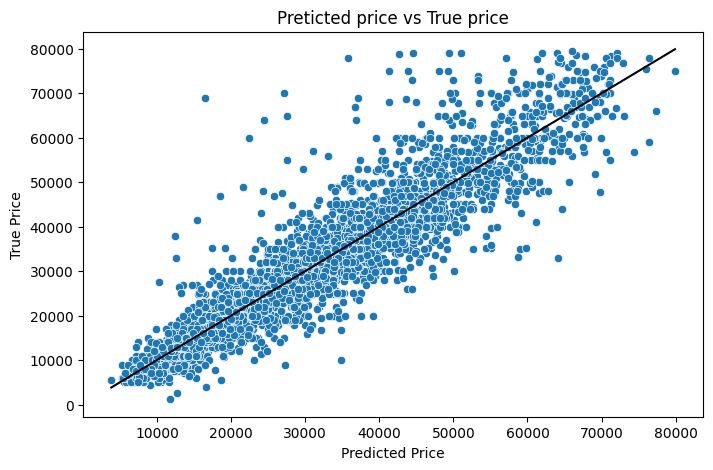

In [38]:
def plot_residuals(y_test_pred, y_test):
  fig, ax = plt.subplots(figsize=(8,5))

  sns.scatterplot(x=y_test_pred, y=y_test, ax=ax)
  sns.lineplot(x=y_test_pred, y=y_test_pred, ax=ax, color='black')

  ax.set_xlabel("Predicted Price")
  ax.set_ylabel("True Price")
  ax.title.set_text('Preticted price vs True price')

  plt.show()


plot_residuals(y_test_pred, y_test)

#### XGBoost Model Explainability Using Shap

Given the best model (from the 10-cross-validation), let's provide some insights about the model prediction (the price):

In [39]:
# TreeExplainer is a special class of shap which optimized to work with tree-based model like XGBoost
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(x_train)

Features impact on the price predictions using a beeswarm plot

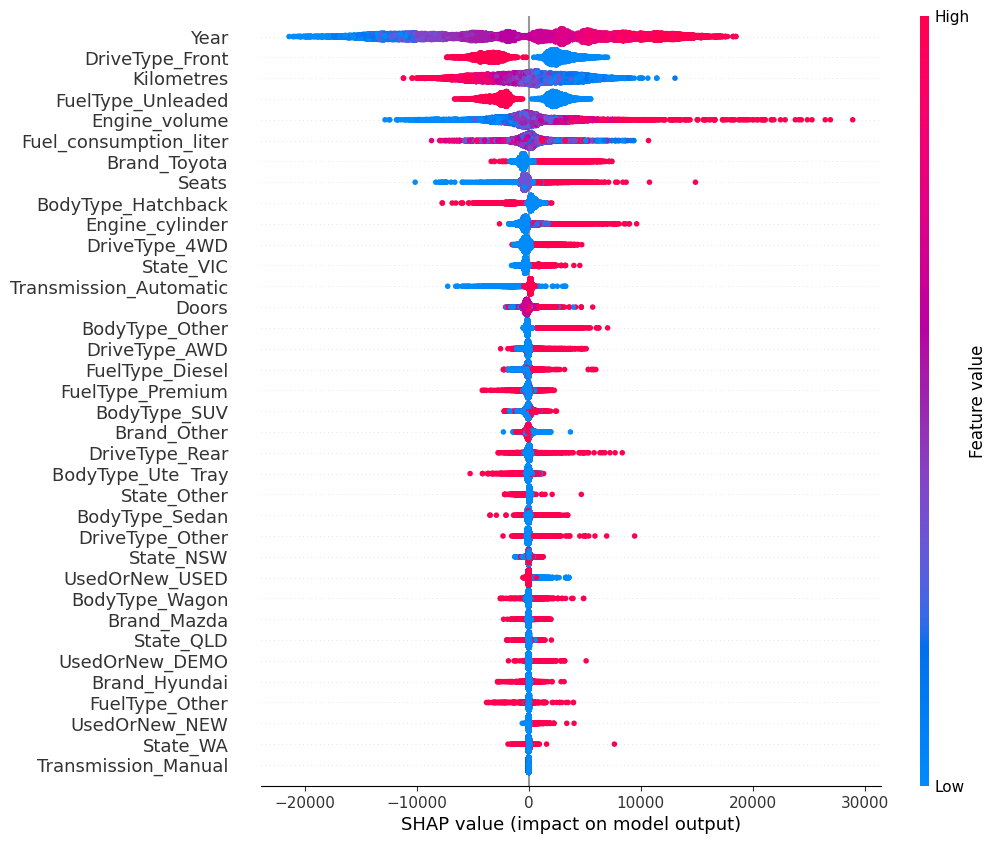

In [40]:
shap.plots.beeswarm(shap_values,  max_display=x_train.shape[1], plot_size=(10,10))

The beeswarm plot indicates that the year has the most impact on the price prediction - higher year values increase the price, while a lower year values decrease the price. We can also see that lower kilometers values increase the price (in the correlation section - we saw an inverse correlation between kilometers and the price), and we can also see that the Transmission_Manual feature has almost no effect on the price.

Another look using the bar plot

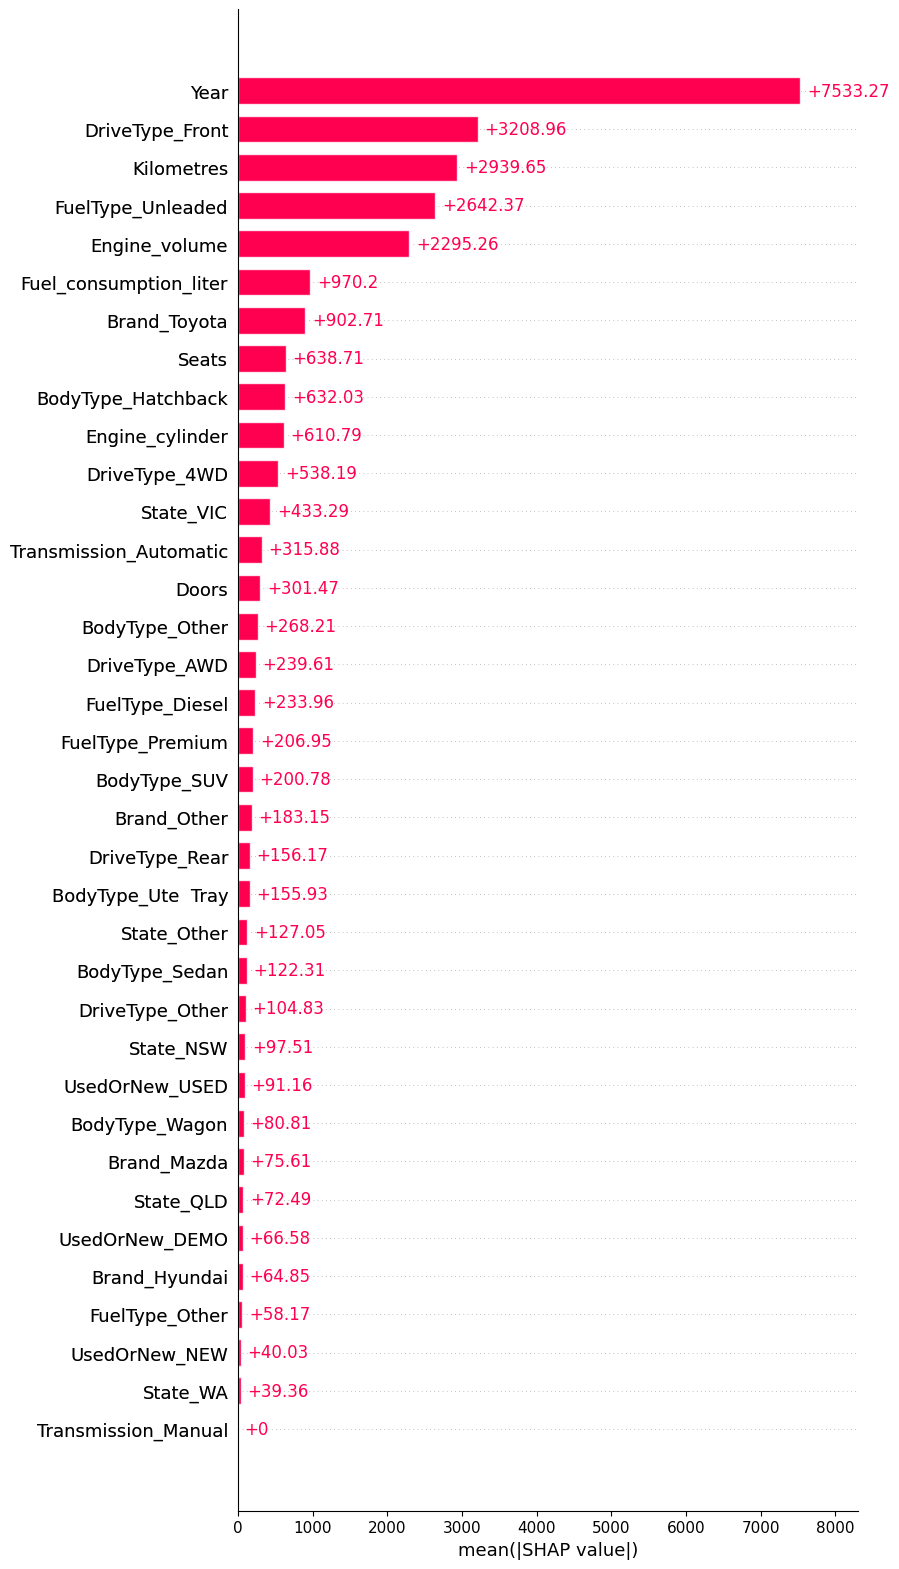

In [41]:
shap.plots.bar(shap_values, max_display=x_train.shape[1])

The bar plot also show that the Year, DriveType_Front, Kilometers, FuelType_Unleaded, Engine_volume are the most important features for the price predictions

According to the above plots, the year feature has the most impact on the price prediction. Let's check the 'Year' impact using dependence plot, which shows the effect a single feature has on the predictions made by the model. We use kilometres as the interaction_index.

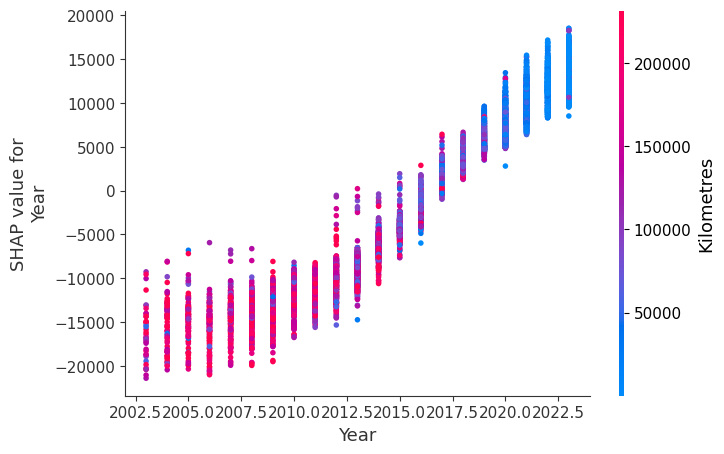

In [42]:
shap.dependence_plot("Year", shap_values.values, x_train, interaction_index="Kilometres")

This plot also show the importance of the year feature. This plot also demonstrate the inverse correlation between the year vs kilometres features that we saw in the correlation part - higher year values correspond to a lower kilometers values and vice versa.

## Improve ML pipeline

#### Better Skewness & Kurtosis Handling

Take another look using skewness and kurtosis methods, to see if we can improve some feature distribution.

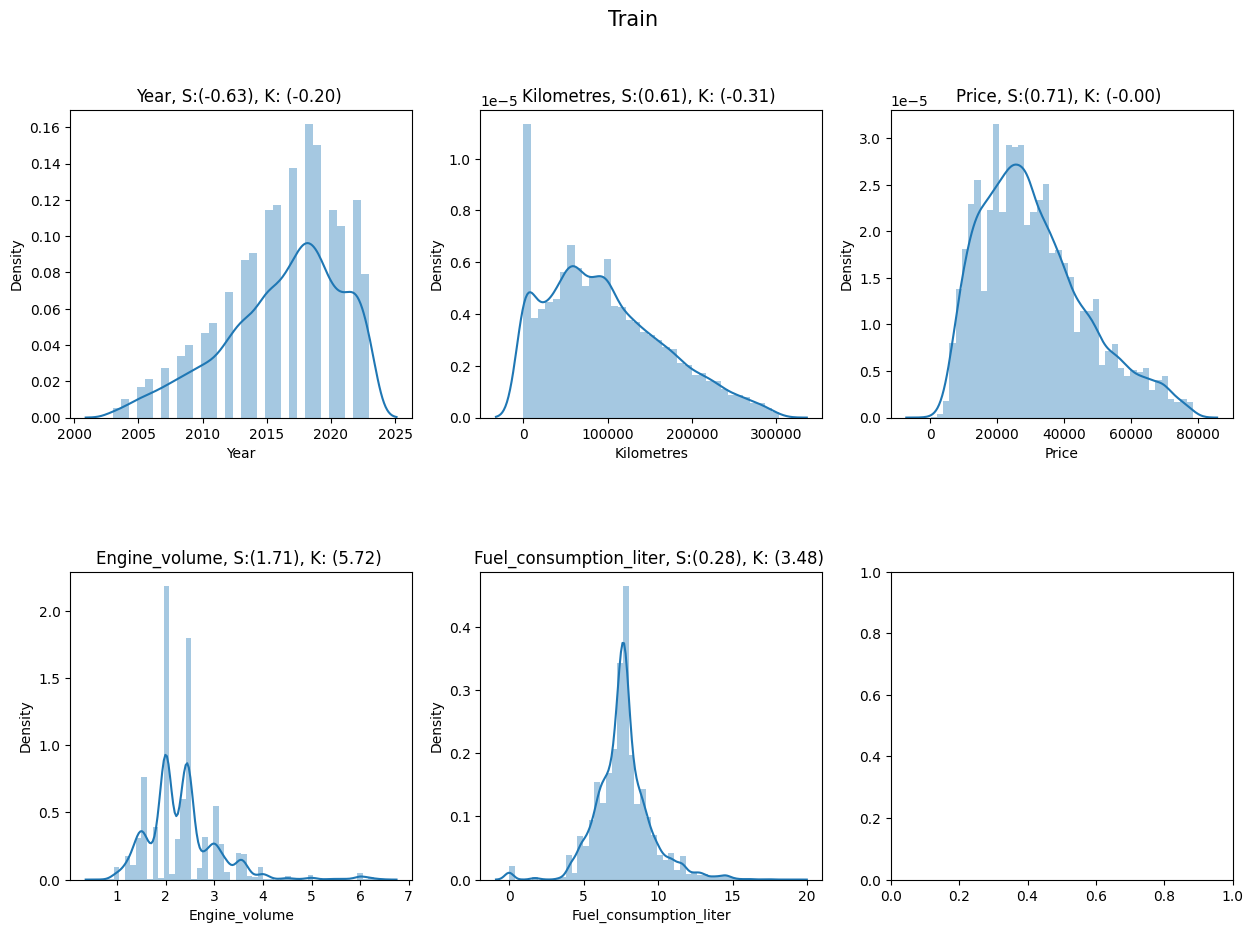

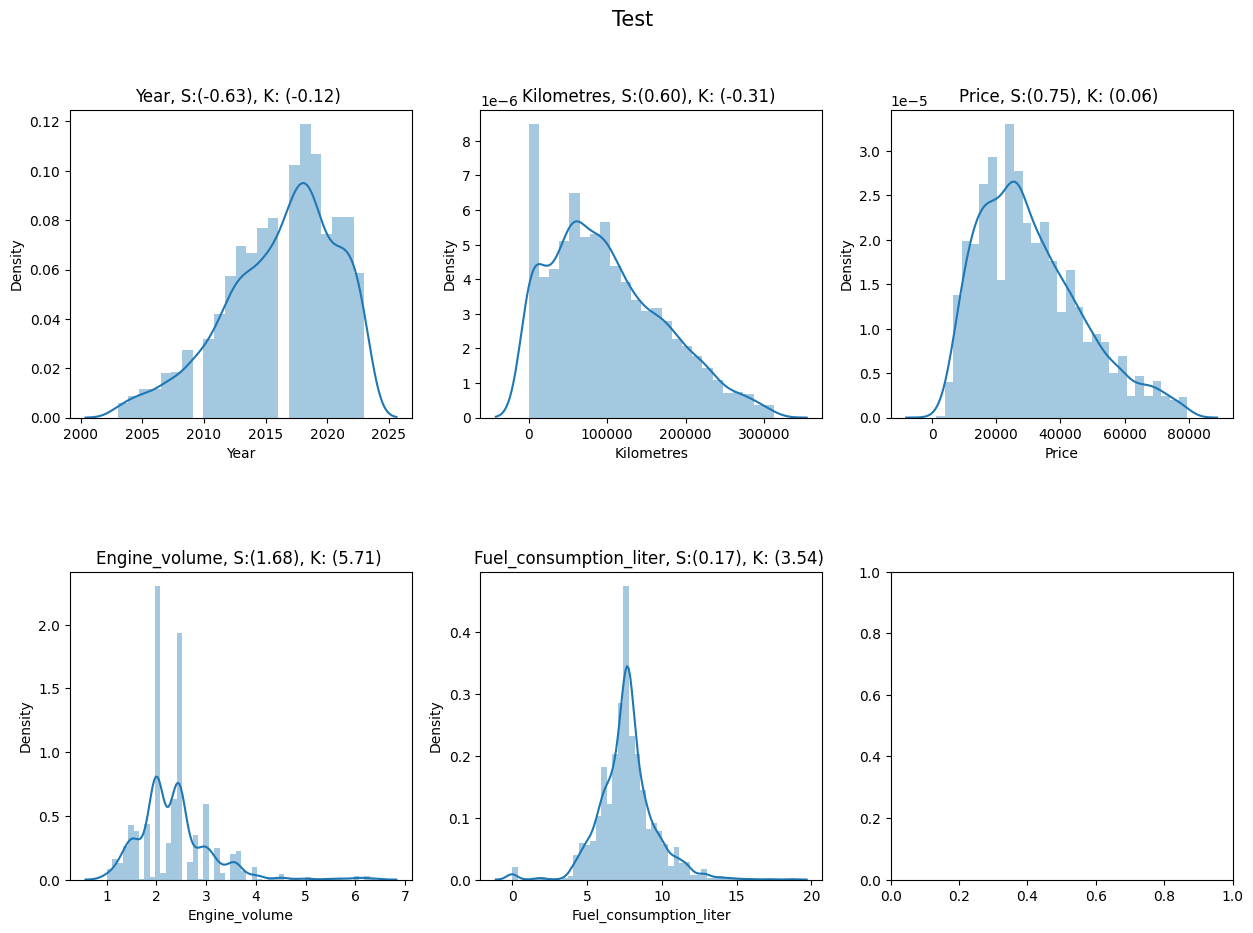

In [43]:
def check_skewness_and_kurtosis(df, name):

  # define very numeric features
  numeric_columns = df.dtypes[(df.dtypes=="float64") | (df.dtypes=="int64")].index.tolist()
  very_numerical = [nc for nc in numeric_columns if df[nc].nunique() > 20]

  # Create a histogram for each categorical attribute
  n = len(very_numerical)
  cols = 3
  rows = (n//3) + 1 if n%3 !=0 else n//3

  # Generate a grid:
  fig, axes = plt.subplots(rows,cols,figsize=(cols*5, rows*5))
  fig.suptitle(name, fontsize=15)
  fig.subplots_adjust(hspace=0.5)

  for i, column in enumerate(very_numerical):
      # Current place on the grid
      r = int(i/cols)
      c = i%cols

      # build the histograms
      sns.distplot(df[column],ax=axes[r,c],kde=True)
      axes[r,c].set_title(f"{column}, S:({df[column].skew():.2f}), K: ({df[column].kurt():.2f}) ")

check_skewness_and_kurtosis(df_train, 'Train')
check_skewness_and_kurtosis(df_test, 'Test')

*   We can see that Fuel_consumption_liter has a small skewness value (distribution is approximately symmetric), and it's kurtosis value is very close to the kurtosis of the normal distribution which is 3.

*   Engine_volume has a large skewness & kurtosis value, while the other features  distribution is moderately skewed (relatively low, because we removed the outliers, in the outliers section), and have light tails.

*   Apply log(x) or sqrt(x) are among the most common methods to handle skewness.

*   After some testing, we see that, Engine_volume is better with log(x), while the others are better with sqrt(x)





In [44]:
features = ['Engine_volume', 'Price', 'Kilometres', 'Year']

for feature in features:
  if feature in ['Price', 'Kilometres', 'Year']:
    df_train[feature] = df_train[feature].apply(np.sqrt)
    df_test[feature] = df_test[feature].apply(np.sqrt)
  else:
    df_train[feature] = df_train[feature].apply(np.log)
    df_test[feature] = df_test[feature].apply(np.log)

  # calculate the price's Skewness & Kurtosis
  print(f"Train: {feature} Skewness:({df_train[feature].skew():.2f}), {feature} Kurtosis:({df_train[feature].kurt():.2f})")
  print(f"Test: {feature} Skewness:({df_test[feature].skew():.2f}), {feature} Kurtosis:({df_test[feature].kurt():.2f})\n")

Train: Engine_volume Skewness:(0.19), Engine_volume Kurtosis:(0.93)
Test: Engine_volume Skewness:(0.20), Engine_volume Kurtosis:(0.91)

Train: Price Skewness:(0.16), Price Kurtosis:(-0.50)
Test: Price Skewness:(0.19), Price Kurtosis:(-0.51)

Train: Kilometres Skewness:(-0.41), Kilometres Kurtosis:(-0.34)
Test: Kilometres Skewness:(-0.41), Kilometres Kurtosis:(-0.33)

Train: Year Skewness:(-0.63), Year Kurtosis:(-0.20)
Test: Year Skewness:(-0.63), Year Kurtosis:(-0.12)



10-cross-validation, and evaluate results

x_train.shape: (11194, 36)
y_train.shape: (11194,)
x_test.shape: (3734, 36)
y_test.shape: (3734,)

Train results:
Negative Mean Absolute Error : -11 (+/- 0)
Negative Root Mean Squared Error : -15 (+/- 1)
R2 : 0.8797 (+/- 0.0075)
Max Error : -96 (+/- 19)


the best model index: 3


Test results:
Negative Mean Absolute Error: -11.303
Negative Root Mean Squared Error: -15.891
R2: 0.878
Max Error: 129.907




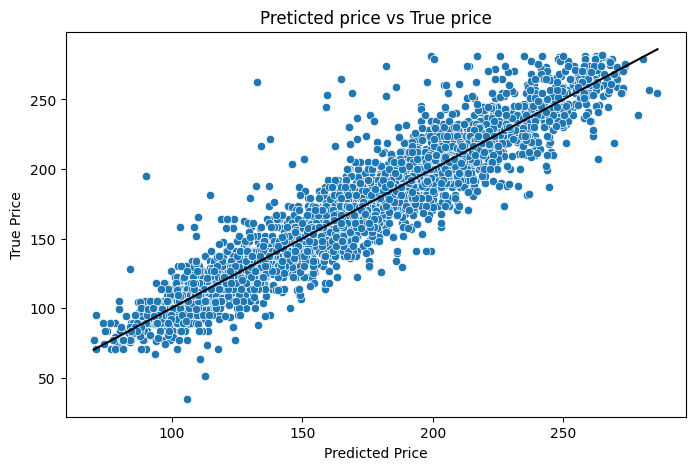

In [45]:
# separate x from y
x_train = df_train.drop('Price',axis=1)
y_train = df_train['Price']

print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")

x_test = df_test.drop('Price',axis=1)
y_test = df_test['Price']

print(f"x_test.shape: {x_test.shape}")
print(f"y_test.shape: {y_test.shape}\n")

# Train
results = run_10_cross_validation(XGBRegressor(), x_train, y_train)
evaluate_results(results)

print('\n')

# Test
best_model = get_the_best_model(results)
print('\n')
y_test_pred = evaluate_test_results(best_model, x_test, y_test)
print('\n')
plot_residuals(y_test_pred, y_test)

**As you can see, the R2 improved from 85%-86% (before), to 87%-88% (now)**

#### Better Feature engineering

*   Remember that we decided to group together each brand type with less than 800 instances into a new type - "Brand_Other".
*   Because there are so many unique brands types (55+), and each one has a completely different impact on the price, we actually lost a lot of necessary information.
*   For example, suppose there are two brands types that have less than 800 instances, but their price impact is completely different (for example, a certain brand type will increase the price a lot, while the other has almost no effect), so when we decided to group them into the same category ("Brand_Other"), we actually gave them the same effect on the price.
*   If we divide it in a better way, we will see in the shap bar plot, different types of brands ranked higher (demonstrates their actual effect), while before they where all grouped together in the Brand_Other, and lost their price impact.

* We will combine types with less than 100 instances into 'Brand_Other'.



In [46]:
# Save the old Brand_ df:
old_brand_train_df = df_train.filter(regex='Brand_')
old_brand_test_df = df_test.filter(regex='Brand_')

# Saved the old 'Brand_' features
df_train = df_train[df_train.columns.drop(list(old_brand_train_df))]
df_test = df_test[df_test.columns.drop(list(old_brand_test_df))]

# Removed 'Brand_Other'
old_brand_train_df.drop(['Brand_Other'], axis=1, inplace=True)
old_brand_test_df.drop(['Brand_Other'], axis=1, inplace=True)

print(f"old_brand_train_df.columns: {old_brand_train_df.columns}")
print(f"old_brand_test_df.columns: {old_brand_test_df.columns}\n")

# Define high brand categories (df_train_brand_copy stored the original train brand df)
brand_value_count = df_train_brand_copy.value_counts()
print(f"Train brand_value_count:\n{brand_value_count}\n")
brand_high_categories = brand_value_count[brand_value_count >= 100]
print(f"Train brand_high_categories:\n{brand_high_categories}\n")

# Create a new 'Brand_' categories:
train_brand_df = df_train_brand_copy.apply(lambda x: x if x in brand_high_categories else 'Other')
test_brand_df = df_test_brand_copy.apply(lambda x: x if x in brand_high_categories else 'Other')

# Get dummy variables for training data and concatenate to dummy_train DataFrame
dummy_brand_train = pd.get_dummies(train_brand_df, prefix=train_brand_df.name, dtype=int)

# Get dummy variables for testing data and concatenate to dummy_test DataFrame
dummy_brand_test = pd.get_dummies(test_brand_df, prefix=test_brand_df.name, dtype=int)

# Concatenate dummy_brand_train and dummy_brand_test to df_train and df_test respectively
df_train = pd.concat([df_train, dummy_brand_train], axis=1)
df_test = pd.concat([df_test, dummy_brand_test], axis=1)

old_brand_train_df.columns: Index(['Brand_Hyundai', 'Brand_Mazda', 'Brand_Toyota'], dtype='object')
old_brand_test_df.columns: Index(['Brand_Hyundai', 'Brand_Mazda', 'Brand_Toyota'], dtype='object')

Train brand_value_count:
Brand
Toyota           1762
Hyundai           901
Mazda             849
Holden            776
Mitsubishi        749
Ford              737
Nissan            668
Volkswagen        619
Kia               607
Subaru            430
Mercedes-Benz     361
Audi              294
BMW               292
Honda             255
MG                231
Suzuki            221
Jeep              194
GWM               147
Isuzu             135
Renault           132
Land              114
Lexus             107
Volvo              84
LDV                77
Skoda              70
Ssangyong          53
Mini               50
Peugeot            42
Fiat               33
Porsche            31
Jaguar             25
Chrysler           18
HSV                17
Haval              15
Great              12

New Brand categories

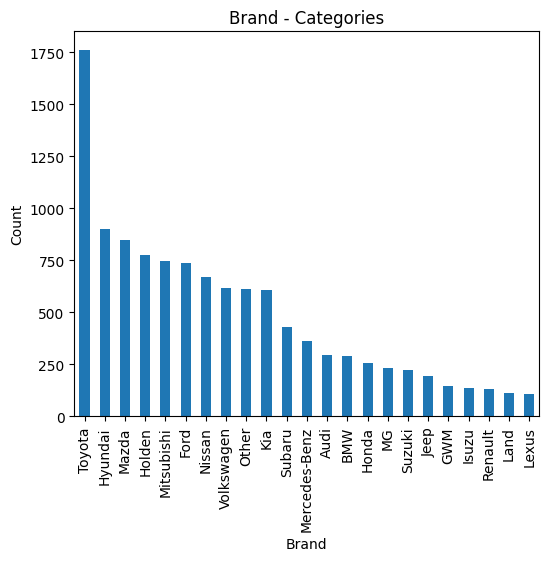

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

# Plot the bar chart for the column
train_brand_df.value_counts().plot(kind='bar', title='Brand - Categories')
axes.set_ylabel('Count')

plt.show()

10 cross validation, and evaluate results

x_train.shape: (11194, 55)
y_train.shape: (11194,)
x_test.shape: (3734, 55)
y_test.shape: (3734,)

Train results:
Negative Mean Absolute Error : -10 (+/- 0)
Negative Root Mean Squared Error : -14 (+/- 1)
R2 : 0.9006 (+/- 0.0092)
Max Error : -99 (+/- 23)


the best model index: 4


Test results:
Negative Mean Absolute Error: -10.241
Negative Root Mean Squared Error: -14.644
R2: 0.897
Max Error: 131.513




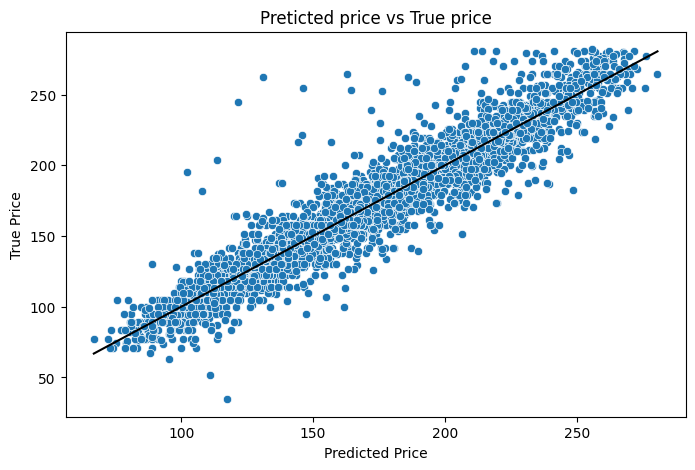

In [48]:
# separate x from y
x_train = df_train.drop('Price',axis=1)
y_train = df_train['Price']

print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")

x_test = df_test.drop('Price',axis=1)
y_test = df_test['Price']

print(f"x_test.shape: {x_test.shape}")
print(f"y_test.shape: {y_test.shape}\n")

# Train
results = run_10_cross_validation(XGBRegressor(), x_train, y_train)
evaluate_results(results)

print('\n')

# Test
best_model = get_the_best_model(results)
print('\n')
y_test_pred = evaluate_test_results(best_model, x_test, y_test)
print('\n')
plot_residuals(y_test_pred, y_test)

**As you can see, the R2 improved from 87%-88% (in the previous cell), to almost 90%**

Let's see the effect on the shap bar plot

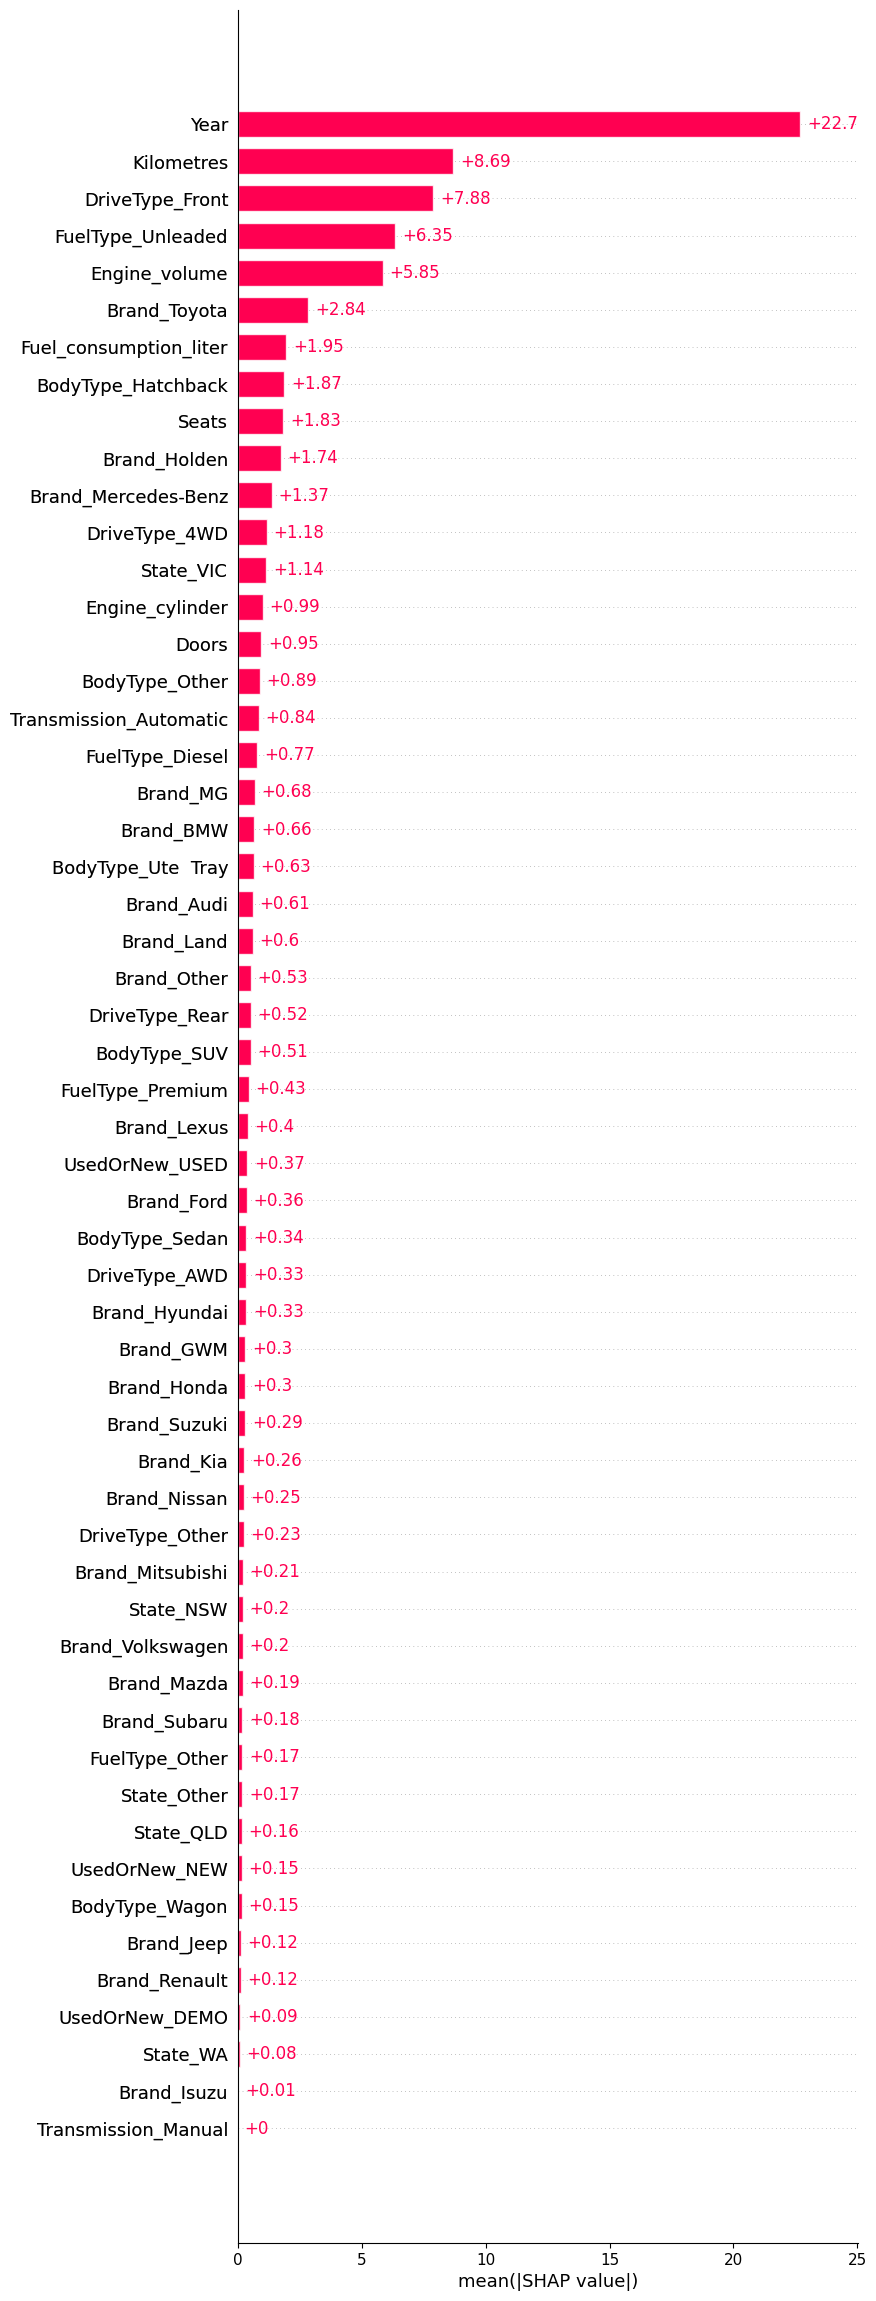

In [49]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(x_train)
shap.plots.bar(shap_values, max_display=x_train.shape[1])

According to the bar plot, you can see new brands types like: Holden, Mercedes-Benz ,Audi, BMW, Land, MG etc, that are ranked higher, which demonstrates their actual price impact - while before, they were all grouped together into the 'Brand_Other'. That's why now, the model's predictions are better


#### XGBRegressor Parameters Tuning

Define a skip variable:

*   skip = True --> load the best model params.
*   skip = False --> run fine tuning, it may take a few times



In [50]:
skip = True

Load the best model params (on the test set)

Best XGBRegressor Params: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 700, 'objective': 'reg:squarederror', 'silent': 0, 'subsample': 1.0}

the best model index: 5


Test results:
Negative Mean Absolute Error: -9.658
Negative Root Mean Squared Error: -13.984
R2: 0.906
Max Error: 113.498




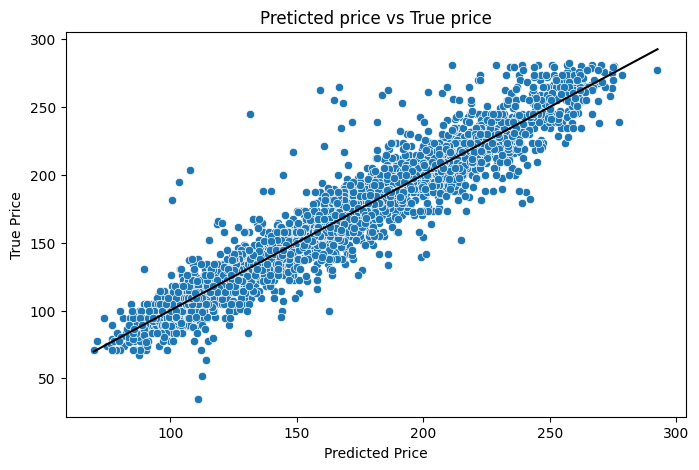

In [51]:
import json

if skip:
  with open('best_params.json', "r") as json_file:
      params = json.load(json_file)

  print(f"Best XGBRegressor Params: {params}\n")

  # define XGBRegressor model with the best params:
  model = XGBRegressor(**params)
  # 10_cross_validation
  results = run_10_cross_validation(model, x_train, y_train)

  # best model from the given params
  best_model = get_the_best_model(results)
  print('\n')
  # evaluate_test
  y_test_pred = evaluate_test_results(best_model, x_test, y_test)
  print('\n')
  plot_residuals(y_test_pred, y_test)

**These are the best test results we got so far**

check our best and final model using shap

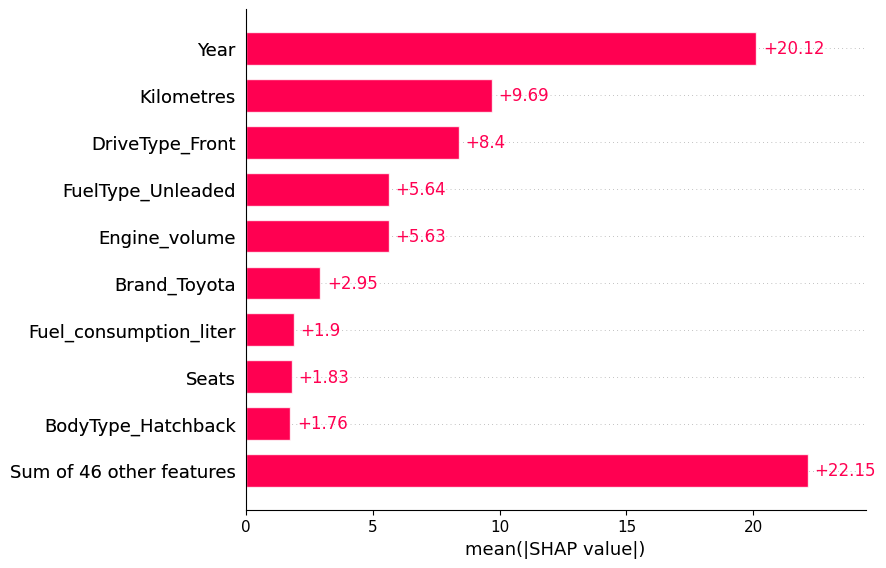

In [52]:
if skip:
  explainer = shap.TreeExplainer(best_model)
  shap_values = explainer(x_test)
  shap.plots.bar(shap_values, max_display=10)

As we see in the previous plots the Year, Kilometers, DriveType_Front, Fuel Type Unleaded, Engine Volume are the most important features for the price predictions.

Try various hyper-parameters to tune, **you can run this part by setting skip = False.**



*   objective: Specifies the learning task and the corresponding objective function.
*   learning_rate: Controls the step size at each iteration of boosting.
*   max_depth: Specifies the maximum depth of a tree.
*   min_child_weight: Defines the minimum sum of instance weight needed in a child.
*   subsample: Specifies the fraction of samples to be used for training each tree.
*   colsample_bytree: Specifies the fraction of features to be used for training each tree.
*   n_estimators: Specifies the number of boosting rounds (trees) to be run.
*   gamma: Specifies the minimum loss reduction required to make a further partition on a leaf node of the tree.

In [53]:
if not skip:
  print("Try various hyper-parameters to tune, it may take a few times")

  # Various hyper-parameters to tune
  parameters = {'objective':['reg:squarederror'],
                'learning_rate': [0.001, 0.01, 0.1],
                'silent' : [0],
                'max_depth': [3, 7],
                'min_child_weight': [1, 5],
                'subsample': [0.6, 1.0],
                'colsample_bytree': [0.6,1.0],
                'n_estimators': [300, 700],
                'gamma': [0.001, 0.1, 1]
                }

  cv = KFold(n_splits=5, shuffle=True)
  xgb_grid = GridSearchCV(XGBRegressor(), parameters, cv=cv , n_jobs=-1, verbose=True)

  # train (with cross-validation)
  xgb_grid.fit(x_train.copy(), y_train.copy())

  print("Best parameters found:")
  best_params = xgb_grid.best_params_
  print(best_params)

  print("Best score found:")
  print(xgb_grid.best_score_)

  # save the best model params:
  with open("best_params.json", "w") as json_file:
    json.dump(best_params, json_file)

  print("Best parameters saved to 'best_params.json'.")

  # Get the best model
  best_model = xgb_grid.best_estimator_

  # test
  y_test_pred = evaluate_test_results(best_model, x_test.copy(), y_test.copy())

#### Handle Imbalanced Data

We have an imbalanced data problem with the seat feature

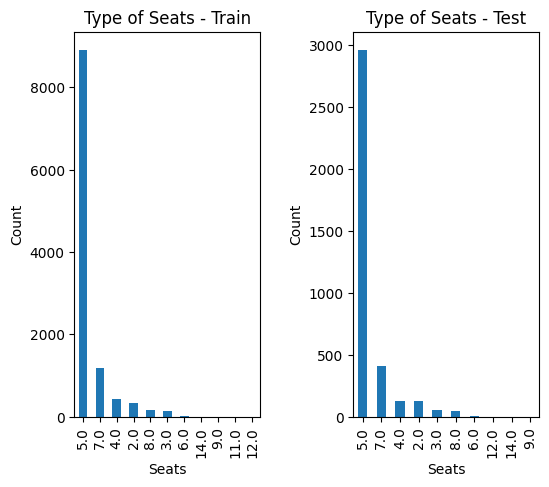

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 5))

# train seats
df_train['Seats'].value_counts().plot(kind='bar', ax=axes[0], title='Type of Seats - Train')
axes[0].set_ylabel('Count')

# test seats
df_test['Seats'].value_counts().plot(kind='bar',ax=axes[1],title='Type of Seats - Test')
axes[1].set_ylabel('Count')

plt.subplots_adjust(wspace=0.5)
plt.show()

We will convert the seats into a categorical feature:

*   Seats Categories: 2-4, 5-7, 8-10

After that, we will use an over-sampling technique called **SMOTE**, which is a method to address the class imbalance problem, where one class (the minority class) is significantly underrepresented compared to the other classes (the majority class or classes).

By creating these synthetic samples, SMOTE helps balance the class distribution (of Seats), making the minority class more represented.

Finally, we will apply ordinal encoding (to preserve the ordinal relationship between categories) to the seats feature acccording to this mapping: '2-4' to 3, '5-7' to 6 and '8-10' to 9.


In [55]:
def map_seat_to_category(seats):
    if seats in range(2, 5):
        return '2-4'
    elif seats in range(5, 8):
        return '5-7'
    elif seats in range(8, 11):
        return '8-10'
    else:
        return None  # Return None for seats outside of the specified range


def create_feature_categories(df, feature):
  # apply new categories
  df[feature] = df[feature].apply(map_seat_to_category)

  # remove rows with number that is outside of the specified categories
  df = df.dropna(subset=[feature])

  return df


# ordinal encoding
def seats_ordinal_encoding(df):
  seats_order = ['2-4', '5-7', '8-10']

  # Perform ordinal encoding
  df['Seats'] = df['Seats'].apply(lambda x: (seats_order.index(x) + 1) * 3)
  df['Seats'] = df['Seats'].astype(int)

  return df


def add_samples(df, feature):
  # separate the features and target variable
  X = df.drop(columns=[feature])
  y = df[feature]

  # initialize SMOTE & apply smote
  smote = SMOTE(sampling_strategy='auto')
  X_resampled, y_resampled = smote.fit_resample(X, y)

  # concatenate the resampled data with the original DataFrame
  resampled_df = pd.concat([X_resampled, y_resampled], axis=1)

  # concatenate resampled data with the original DataFrame
  df = pd.concat([df, resampled_df], ignore_index=True)

  # shuffle the DataFrame to mix the new samples with existing ones
  df = df.sample(frac=1).reset_index(drop=True)

  return df



# create copies of train, test df:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

# Train
df_train_copy = create_feature_categories(df_train_copy, 'Seats')
df_train_copy = seats_ordinal_encoding(df_train_copy)
df_train_copy = add_samples(df_train_copy, 'Seats')

# Test
df_test_copy = create_feature_categories(df_test_copy, 'Seats')
df_test_copy = seats_ordinal_encoding(df_test_copy)
df_test_copy = add_samples(df_test_copy, 'Seats')

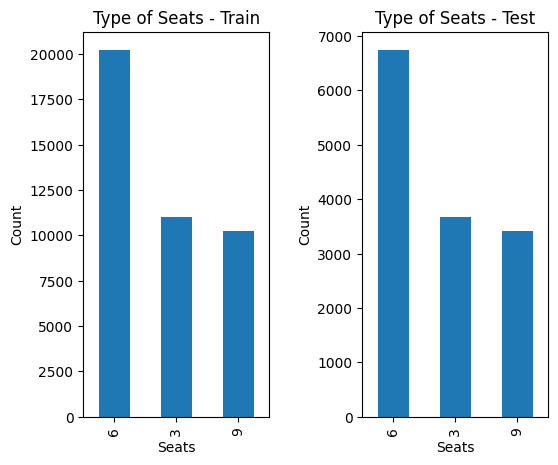

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 5))

# train seats
df_train_copy['Seats'].value_counts().plot(kind='bar', ax=axes[0], title='Type of Seats - Train')
axes[0].set_ylabel('Count')

# test seats
df_test_copy['Seats'].value_counts().plot(kind='bar',ax=axes[1],title='Type of Seats - Test')
axes[1].set_ylabel('Count')

plt.subplots_adjust(wspace=0.5)
plt.show()

Remembered that '2-4' seats is 3, '5-7' is 6 and '8-10' is 9

Run 10-cross-validation, and evaluate results

In [57]:
# separate x from y
x_train_copy = df_train_copy.drop('Price',axis=1)
y_train_copy = df_train_copy['Price']

print(f"x_train.shape: {x_train_copy.shape}")
print(f"y_train.shape: {y_train_copy.shape}")

x_test_copy = df_test_copy.drop('Price',axis=1)
y_test_copy = df_test_copy['Price']

print(f"x_test.shape: {x_test_copy.shape}")
print(f"y_test.shape: {y_test_copy.shape}\n")

# Train
results = run_10_cross_validation(XGBRegressor(), x_train_copy, y_train_copy)
evaluate_results(results)

print('\n')

# Test
best_model = get_the_best_model(results)
print('\n')
y_test_copy_pred = evaluate_test_results(best_model, x_test_copy, y_test_copy)

x_train.shape: (41498, 55)
y_train.shape: (41498,)
x_test.shape: (13837, 55)
y_test.shape: (13837,)

Train results:
Negative Mean Absolute Error : -8 (+/- 0)
Negative Root Mean Squared Error : -11 (+/- 0)
R2 : 0.9400 (+/- 0.0030)
Max Error : -75 (+/- 16)


the best model index: 6


Test results:
Negative Mean Absolute Error: -10.701
Negative Root Mean Squared Error: -14.793
R2: 0.895
Max Error: 104.071


It didn't improve the test results (only improved the training set), so we will try a different approach.

#### Feature Selection

*  We have many features, so we are looking for a feature reduction - removes features that won't impact the price prediction. Such features may be those with a small correlation to the price, and we can also see who has the least impact on the price thanks to the shap plots.

*  With the help of the shap plots we can see which of the features have the smallest impact on predicted price. We will remove features with a shap value less than 0.3 (according to the bar plot).

*  We saw in the previous correlation sections that the 'Fuel_consumption_liter', 'Seats', and 'Engine_cylinder' have the lowest correlation to the price feature. But according to the shap plots, they all have a big impact in the price, so we won't remove them (when i removed them, it didn't improve the results).

*  Highly correlated features essentially provide the same information, so when two features are strongly correlated, one of them becomes redundant as it doesn’t add new or unique information to the model

*  We saw in the previous sections that the highest correlated features are:  'Engine_cylinder', and 'Engine_volume', and an inverse correlation between the 'Year' and 'Kilometers'. When we removed one feature from each of these pairs, the result was worse than before - which make sense because according to the shap plots the 'Year', 'Kilometers', 'Engine_cylinder', and 'Engine_volume' are features have a big impact on the price predictions. **So, finally we will remove features with shap value less than 0.3**




Let's implement the above insights, and measure results

In [58]:
# returns a df of features sorted by their shap importance
def shap_importance(shap_values):

    shap_values_dict = {"": shap_values}
    values = list(shap_values_dict.values())

    for i in range(len(values)):
        if len(values[i].shape) == 2:
            values[i] = values[i].abs.mean(0)

    features = values[0].data
    feature_names = values[0].feature_names
    values = np.array([values[i].values for i in range(len(values))])

    feature_importance = pd.DataFrame(list(zip(feature_names, sum(values))), columns=['features', 'importance'])

    feature_importance.sort_values(by=['importance'], ascending=False, inplace=True)

    return feature_importance


shap_importance_df = shap_importance(shap_values)

# features with less than 0.3
unimportant_features = shap_importance_df[shap_importance_df.importance < 0.3]

print(f"Removed: {list(unimportant_features.features)}")

# create a copy of train & test df, and remove the unimportant features
x_train_copy = x_train.copy().drop(list(unimportant_features.features),axis=1)
x_test_copy = x_test.copy().drop(list(unimportant_features.features),axis=1)

Removed: ['Brand_GWM', 'BodyType_Wagon', 'Brand_Suzuki', 'Transmission_Manual', 'Brand_Hyundai', 'Brand_Mitsubishi', 'Brand_Kia', 'Brand_Honda', 'Brand_Mazda', 'DriveType_Other', 'Brand_Volkswagen', 'UsedOrNew_NEW', 'FuelType_Other', 'Brand_Subaru', 'State_QLD', 'Brand_Jeep', 'State_Other', 'State_WA', 'Brand_Renault', 'UsedOrNew_DEMO', 'Brand_Isuzu']


Check if the feature selection, improve the results. We wil run again the 10-cross-validation, and evaluate results

In [59]:
# Train
results = run_10_cross_validation(XGBRegressor(), x_train_copy, y_train)
evaluate_results(results)

print('\n')

# Test
best_model = get_the_best_model(results)
print('\n')
y_test_pred = evaluate_test_results(best_model, x_test_copy, y_test)

Train results:
Negative Mean Absolute Error : -10 (+/- 0)
Negative Root Mean Squared Error : -14 (+/- 0)
R2 : 0.8975 (+/- 0.0074)
Max Error : -90 (+/- 22)


the best model index: 0


Test results:
Negative Mean Absolute Error: -10.723
Negative Root Mean Squared Error: -15.028
R2: 0.891
Max Error: 140.577


It didn't improve the results, so we will try a different approach

#### Feature Scaling

* Feature Scaling involves transforming numerical features to a common scale. It ensure accurate and efficient model training and performance and reduce potential biases and inconsistencies that may arise from variations in their values.

* XGBoost is not sensitive to monotonic transformations of its features for the same reason that decision trees and random forests are not: the model only needs to pick "cut points" on features to split a node. Splits are not sensitive to monotonic transformations: defining a split on one scale has a corresponding split on the transformed scale.

* XGBoost is an ensemble algorithm based on decision trees, so doesn't need normalization.

* That's why when try to normalize (scale) numeric features, using StandardScaler it didn't improve the results


In [60]:
def scale_numeric_features(df):
  scaled_features = ['Year', 'Kilometres', 'Engine_volume', 'Engine_cylinder', 'Fuel_consumption_liter', 'Doors', 'Seats']
  features_for_scale = df[scaled_features]

  # apply StandardScaler
  scaler = StandardScaler()
  scaler.fit(features_for_scale)

  x_transform_dt = scaler.transform(features_for_scale)
  x_scaled_df = pd.DataFrame(x_transform_dt, columns=scaled_features)

  df.drop(scaled_features,axis=1,inplace=True)
  df.reset_index(drop=True, inplace=True)
  x_scaled_df.reset_index(drop=True, inplace=True)
  df = pd.concat([df, x_scaled_df], axis=1)

  return df

x_train_copy = scale_numeric_features(x_train.copy())
x_test_copy = scale_numeric_features(x_test.copy())

Again, 10-cross-validation, and evaluate results

In [61]:
# Train
results = run_10_cross_validation(XGBRegressor(), x_train_copy, y_train)
evaluate_results(results)

print('\n')

# Test
best_model = get_the_best_model(results)
print('\n')
y_test_pred = evaluate_test_results(best_model, x_test_copy, y_test)

Train results:
Negative Mean Absolute Error : -10 (+/- 0)
Negative Root Mean Squared Error : -14 (+/- 1)
R2 : 0.9030 (+/- 0.0070)
Max Error : -98 (+/- 23)


the best model index: 7


Test results:
Negative Mean Absolute Error: -11.755
Negative Root Mean Squared Error: -16.421
R2: 0.87
Max Error: 130.205


As we said, it didn't improve the results.

#### Try a different model - Random Forest



*   Random forests build multiple decision trees and average their predictions
*   Random forests are less sensitive to outliers

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# define model
model = RandomForestRegressor()

# Train
results = run_10_cross_validation(model, x_train, y_train)
evaluate_results(results)

print('\n')

# Test
best_model = get_the_best_model(results)
print('\n')
y_test_pred = evaluate_test_results(best_model, x_test, y_test)

Train results:
Negative Mean Absolute Error : -11 (+/- 0)
Negative Root Mean Squared Error : -15 (+/- 1)
R2 : 0.8823 (+/- 0.0065)
Max Error : -94 (+/- 20)


the best model index: 2


Test results:
Negative Mean Absolute Error: -11.042
Negative Root Mean Squared Error: -15.504
R2: 0.884
Max Error: 103.409


it didn't improve the results, so we will try a different model

#### Try a different model - Regression Model

Build model Using SK-Learn Regression

In [63]:
from sklearn.linear_model import LinearRegression

# define model
sk_ols_model = LinearRegression()

# Train
results = run_10_cross_validation(sk_ols_model, x_train, y_train)
evaluate_results(results)

print('\n')

# Test
best_model = get_the_best_model(results)
print('\n')
y_test_pred = evaluate_test_results(best_model, x_test, y_test)

Train results:
Negative Mean Absolute Error : -15 (+/- 0)
Negative Root Mean Squared Error : -20 (+/- 0)
R2 : 0.7974 (+/- 0.0092)
Max Error : -113 (+/- 18)


the best model index: 9


Test results:
Negative Mean Absolute Error: -15.13
Negative Root Mean Squared Error: -20.104
R2: 0.805
Max Error: 145.84


The results are much worse than the results we have got so far

## Conclustions

We predicted the car’s price based on various features (numeric, ordinal, categorical), while dealing with many challenges such as missing values, outliers, data imbalance, and complexity of data types.

We systematically improved our baseline ML model, using advanced methods such as:


*   Skewness & Kurtosis - to understand the underlying characteristics of the features, and improved the model performance. We applied the best methods for each feature (Engine_volume was better with log(x), while the others are better with sqrt(x)).
*   Feature engineering - we demonstrated a new method for splitting the brand feature into categories, which improved the model predictions.
*   Handle data imbalance - by generating synthetic samples of the minority class, using the SMOTE technique.
*   Try various models, different params (fine tuning) and feature selection techinques.
*   Analyzed model preformence using shap, provide intuitive and comprehensive explanations for model predictions, and show the impact of each feature.


Our pipeline is different from other available pipelines, for several reasons:

*   Our results are better and more stable and reliable - because every change we tried, was tested using a 10-cross-validation, and the 'train_test_split' method that we used, didn't provide the same train-test sets (with removed the 'random_state' param which controls the seed), unlike other pipelines.
*   Other piplines didn't try to understand underlying characteristics and shape of the features, while we used advanced methods such as skewness & Kurtosis.
*   Other pipelines didn't addressed the data imbalance problem, while we suggest the SMOTE technique.

## References



*   https://shap.readthedocs.io/en/latest/
*   https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
*   https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
*   https://pandas.pydata.org/docs/index.html
*   https://github.com/amitsomech/TDS-COURSE
*   https://www.datacamp.com/tutorial/understanding-skewness-and-kurtosis








